**TO-DO**
* assinalar que owners é que têm um disponent

## Table Of Contents <a id="index"></a>


- [Dataset managing](#dataset)  
- [District Data](#district-data)
- [Data Exploration](#data-exploration)
- [Matrix](#matrix)
  

#### Models
- [**Decision Tree**](#decision-tree)
    - [**Parameter Tunning**](#parameter-tunning)
- [**K-Nearest Neighbor**](#k-nearest-neighbor)
    - [**Parameter Tunning**](#parameter-tunning-2)  
- [**Support-Vector Machines**](#support-vector-machines)
    - [**Parameter Tunning**](#parameter-tunning-3)
- [**Neural Networks**](#neural-networks)
    - [**Parameter Tunning**](#parameter-tunning-4)

#### [Apllying Model](#applying-model)



In [235]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [236]:
def dataset(x, missing = ""):
    return pd.read_csv('Dataset/' + x + '.csv', sep = ';', low_memory = False, na_values = missing_values).rename(str.strip, axis = 'columns')

In [237]:
missing_values = ['?', 'NA', '']
account_data = dataset('account', missing_values)
client_data = dataset('client', missing_values)
disp_data = dataset('disp', missing_values)
district_data = dataset('district', missing_values)
card_train = dataset('card_train', missing_values)
card_test = dataset('card_test')
loan_train = dataset('loan_train', missing_values)
loan_test = dataset('loan_test')
trans_train = dataset('trans_train', missing_values)
trans_test = dataset('trans_test')

We can see the distribution of the district regions for each one of the different regions.

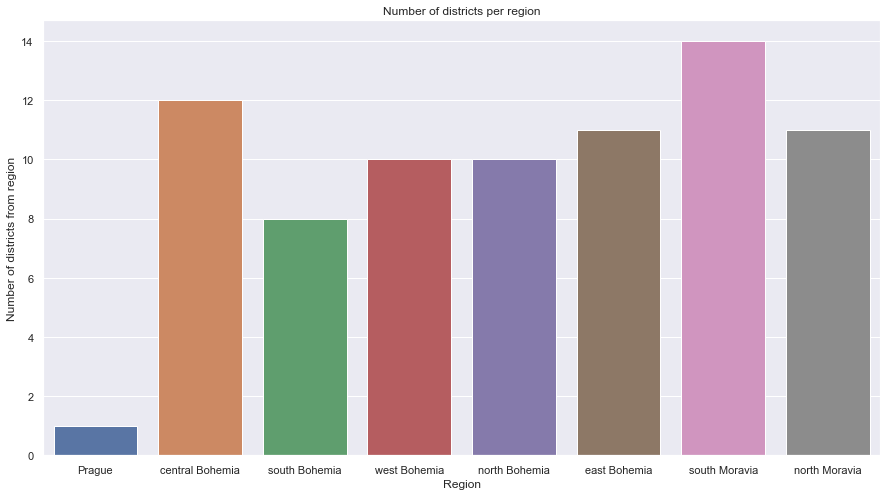

In [238]:
plt.figure(figsize=(15,8))
sb.countplot(x='region', data=district_data)
plt.title("Number of districts per region")
plt.xlabel('Region');
plt.ylabel('Number of districts from region');
plt.show()

To study if the region might have an impact on the acceptance of the loan we will create a graph comparing the percentages of successful loans per region.

C:\Users\pedro\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


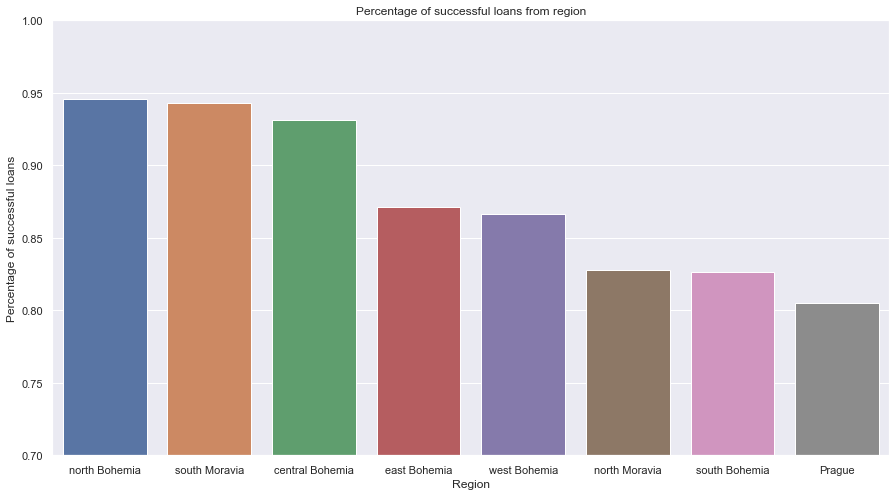

In [239]:
district_data_region = district_data.copy()
region_data = loan_train
region_data = pd.merge(region_data, trans_train, on = 'account_id', suffixes = ('', '_trans'))
region_data = pd.merge(region_data, account_data, on = 'account_id', suffixes = ('', '_account'))
#train_data = train_data.dropna()
region_data = pd.merge(region_data, district_data_region.set_index('code'), left_on = 'district_id', right_index = True, suffixes = ('', '_district'))

region_total = region_data["region"].value_counts()
tuples_total = [tuple((x, y)) for x, y in region_total.items()]

regions_status_1 = region_data.loc[region_data['status'] == 1]
region_total_1 = regions_status_1["region"].value_counts()
tuples_total_1 = [tuple((x, y)) for x, y in region_total_1.items()]

lista=[]
for x in tuples_total:
    for y in tuples_total_1:
        if x[0]==y[0]:
            lista.append((x[0],x[1],y[1]))

percentages = [(i[0],i[2] / i[1]) for i in lista]
percentages.sort(key = lambda x: -x[1])

x = [i[0] for i in percentages]
y = [i[1] for i in percentages]

plt.figure(figsize=(15,8))
sb.barplot(x,y)
plt.ylim(0.7, 1)
plt.title("Percentage of successful loans from region")
plt.xlabel('Region');
plt.ylabel('Percentage of successful loans');
plt.show()

Now let's see the different values the parameter type can have.

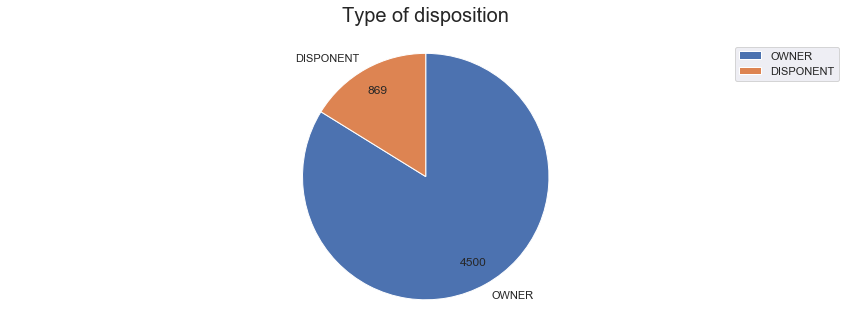

In [240]:
disp_data_pie = disp_data.copy()

ser = disp_data_pie.groupby('type')['type'].count()
ser = ser.sort_values(ascending=False)
ser = ser.iloc[[0,1]]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.pie(ser.values, labels=ser.index, startangle=90, autopct=lambda x:int(x/100.*ser.sum()+0.1), pctdistance=0.8, counterclock=False)
ax.legend()
plt.axis('equal')
plt.title('Type of disposition', y=1.05, fontsize=20)
fig.set_size_inches(15, 5)

Since only owner can issue permanent orders and ask for a loan, there is no interess in keeping this parameter in our dataset.

In [241]:
# Removing name and region from district
district_data.drop(['name', 'region'], axis=1, inplace=True)

# only owner can issue permanent orders and ask for a loan
disp_owners = disp_data[disp_data.type.eq('OWNER')]
disp_owners.drop(['type'], axis=1, inplace=True)

C:\Users\pedro\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [296]:
# Normalize birthday dates and add a new column (Genre) to distinguish

birth_dates = client_data['birth_number']
dates_parsed = []
genre = []
for date in birth_dates:
    month = int(str(date)[2:4])
    if month > 12:
        genre.append(0)
        month = month - 50
        if month < 10:
            month = '0' + str(month)
        else:
            month = str(month)
    else:
        #print('AAAA: ' + str(month))
        if month < 10:
            month = '0' + str(month)
            #print('BBBB: ' + str(month))
        else:
            month = str(month)
        genre.append(1)
    dates_parsed.append(str(date)[:2] + '-' + month + '-' + str(date)[4:])
    
ages = []
for date in dates_parsed:
    born_year = '19' + date[:2]
    age = 1995 - int(born_year)
    ages.append(age)

#client_data = client_data.drop(['birth_number'], axis = 1)
client_data['birth_number'] = dates_parsed

#this are the people's ages in 1995. When merged this will change to people's age at the time of the loan
client_data['age'] = ages
client_data['genre'] = genre
client_data.head()

,client_id,birth_number,district_id,age,genre
0,1,70-0-1-2-13,18,25,1
1,2,45-00-2-04,1,50,1
2,3,40-0-1-0-09,1,55,1
3,4,56-0-1-2-01,5,39,1
4,5,60-00-7-03,5,35,1


We can also see the Genre distribution, where 1 means male and 0 female.

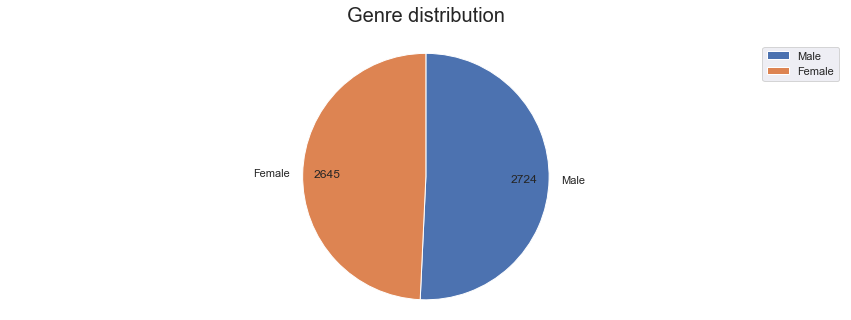

In [244]:
client_data_genre_copy = client_data.copy()

ser = client_data_genre_copy.groupby('genre')['genre'].count()
ser = ser.sort_values(ascending=False)
ser = ser.iloc[[0,1]]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.pie(ser.values, labels=["Male","Female"], startangle=90, autopct=lambda x:int(x/100.*ser.sum()+0.1), pctdistance=0.8, counterclock=False)
ax.legend()
plt.axis('equal')
plt.title('Genre distribution', y=1.05, fontsize=20)
fig.set_size_inches(15, 5)

In [245]:
# build train dataset

train_data = loan_train
train_data = pd.merge(train_data, trans_train, on = 'account_id', suffixes = ('', '_trans'))
train_data = pd.merge(train_data, account_data, on = 'account_id', suffixes = ('', '_account'))
#train_data = train_data.dropna()
train_data = pd.merge(train_data, district_data.set_index('code'), left_on = 'district_id', right_index = True, suffixes = ('', '_district'))
train_data = pd.merge(train_data, disp_owners, on = 'account_id', suffixes = ('', '_disp'))
train_data = pd.merge(train_data, card_train, on = 'disp_id', how = 'outer', suffixes = ('', '_card'))
train_data = pd.merge(train_data, client_data, on = 'client_id', suffixes = ('', '_client'))
train_data = train_data.drop(['district_id_client'], axis=1)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24494 entries, 0 to 24493
Data columns (total 40 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   loan_id                                           24494 non-null  float64
 1   account_id                                        24494 non-null  float64
 2   date                                              24494 non-null  float64
 3   amount                                            24494 non-null  float64
 4   duration                                          24494 non-null  float64
 5   payments                                          24494 non-null  float64
 6   status                                            24494 non-null  float64
 7   trans_id                                          24494 non-null  float64
 8   date_trans                                        24494 non-null  float64
 9   type             

In [246]:
train_data.head()

,loan_id,account_id,date,amount,duration,payments,status,trans_id,date_trans,type,...,no. of commited crimes '95,no. of commited crimes '96,disp_id,client_id,card_id,type_card,issued,birth_number,age,genre
0,5314.0,1787.0,930705.0,96396.0,12.0,8033.0,-1.0,523621.0,930322.0,credit,...,2985.0,2804.0,2166,2166.0,NaN,NaN,NaN,47-07-22,48,0
1,5314.0,1787.0,930705.0,96396.0,12.0,8033.0,-1.0,524054.0,930421.0,credit,...,2985.0,2804.0,2166,2166.0,NaN,NaN,NaN,47-07-22,48,0
2,5314.0,1787.0,930705.0,96396.0,12.0,8033.0,-1.0,524055.0,930521.0,credit,...,2985.0,2804.0,2166,2166.0,NaN,NaN,NaN,47-07-22,48,0
3,5314.0,1787.0,930705.0,96396.0,12.0,8033.0,-1.0,524056.0,930620.0,credit,...,2985.0,2804.0,2166,2166.0,NaN,NaN,NaN,47-07-22,48,0
4,6903.0,9337.0,940604.0,52128.0,24.0,2172.0,1.0,2820215.0,930913.0,credit,...,2985.0,2804.0,11189,11497.0,NaN,NaN,NaN,59-07-17,36,0


In [247]:
# build test dataset

test_data = loan_test
test_data = pd.merge(test_data, trans_test, on = 'account_id', suffixes = ('', '_trans'))
test_data = pd.merge(test_data, account_data, on = 'account_id', suffixes = ('', '_account'))
test_data = pd.merge(test_data, district_data.set_index('code'), left_on = 'district_id', right_index = True, suffixes = ('', '_district'))
test_data = pd.merge(test_data, disp_owners, on = 'account_id', suffixes = ('', '_disp'))
test_data = pd.merge(test_data, card_test, on = 'disp_id', how = 'outer', suffixes = ('', '_card'))
test_data = pd.merge(test_data, client_data, on = 'client_id', suffixes = ('', '_client'))
test_data = test_data.drop(['district_id_client'], axis=1)
test_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 30200 entries, 0 to 30199
Data columns (total 40 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   loan_id                                           30200 non-null  int64  
 1   account_id                                        30200 non-null  int64  
 2   date                                              30200 non-null  int64  
 3   amount                                            30200 non-null  int64  
 4   duration                                          30200 non-null  int64  
 5   payments                                          30200 non-null  int64  
 6   status                                            0 non-null      float64
 7   trans_id                                          30200 non-null  int64  
 8   date_trans                                        30200 non-null  int64  
 9   type             

In [248]:
test_data.head()

,loan_id,account_id,date,amount,duration,payments,status,trans_id,date_trans,type,...,no. of commited crimes '95,no. of commited crimes '96,disp_id,client_id,card_id,type_card,issued,birth_number,age,genre
0,5895,4473,970103,93960,60,1566,NaN,1309867,951009,credit,...,2080.0,2122,5395,5395,NaN,NaN,NaN,62-06-01,33,1
1,5895,4473,970103,93960,60,1566,NaN,1309878,951107,credit,...,2080.0,2122,5395,5395,NaN,NaN,NaN,62-06-01,33,1
2,5895,4473,970103,93960,60,1566,NaN,1310161,951108,credit,...,2080.0,2122,5395,5395,NaN,NaN,NaN,62-06-01,33,1
3,5895,4473,970103,93960,60,1566,NaN,3664951,951130,credit,...,2080.0,2122,5395,5395,NaN,NaN,NaN,62-06-01,33,1
4,5895,4473,970103,93960,60,1566,NaN,1309879,951207,credit,...,2080.0,2122,5395,5395,NaN,NaN,NaN,62-06-01,33,1


Now we can create an age column where we will keep the age of the client at the time of the requested loan.

In [249]:
loan_dates = train_data['date']

loan_dates = [str(int(x))[:2] + "-" + str(int(x))[2:4] + "-" + str(int(x))[4:] for x in loan_dates]

birth_dates = train_data['birth_number']

#print(sorted(birth_dates))

#print(len(birth_dates))
#print(sorted(birth_dates))

from datetime import date
 
def calculateAge(birthDate, loanDate):
    loan = loanDate.split("-")
    loan_date = date(int(loan[0]), int(loan[1]), int(loan[2]))
    birth = birthDate.split("-")
    
    birth_date = date(int(birth[0]), int(birth[1]), int(birth[2]))
    return (int((loan_date-birth_date).days/365))

age_list = [calculateAge(birth_dates[n],loan_dates[n]) for n in range(0,len(birth_dates))]

train_data["age"] = age_list

print(train_data["age"])

0        45
1        45
2        45
3        45
4        34
         ..
24489    33
24490    33
24491    33
24492    33
24493    33
Name: age, Length: 24494, dtype: int64


Now let's do the same for the test data

In [250]:
loan_dates = test_data['date']

loan_dates = [str(int(x))[:2] + "-" + str(int(x))[2:4] + "-" + str(int(x))[4:] for x in loan_dates]

birth_dates = test_data['birth_number']

age_list = [calculateAge(birth_dates[n],loan_dates[n]) for n in range(0,len(test_data))]

test_data["age"] = age_list

print(test_data["age"])

0        34
1        34
2        34
3        34
4        34
         ..
30195    46
30196    46
30197    46
30198    46
30199    46
Name: age, Length: 30200, dtype: int64


<Figure size 432x288 with 0 Axes>

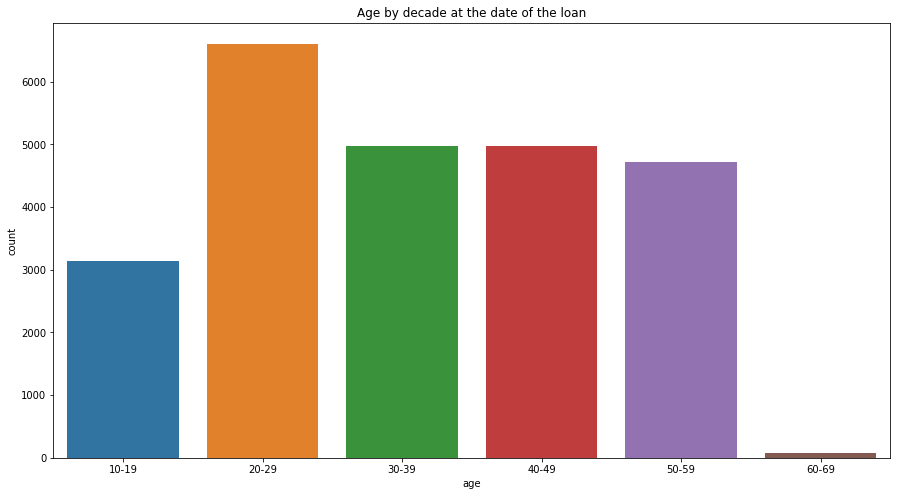

In [251]:
def get_decade(year):
    year_int = int(year)
    string = str(year_int//10) + "0-" + str(year_int//10) + "9"
    return string

train_data_copy = train_data.copy()

train_data_copy = train_data_copy.astype({'age': str})

train_data_copy['age'] = train_data_copy['age'].apply(lambda x: get_decade(x))

train_data_copy = train_data_copy.sort_values('age')

fig = plt.figure()
plt.figure(figsize=(15,8))
plt.title("Age by decade at the date of the loan")
ax = sb.countplot(x="age", data=train_data_copy)
plt.show()

Now we can see the months when the accounts were created.

<Figure size 432x288 with 0 Axes>

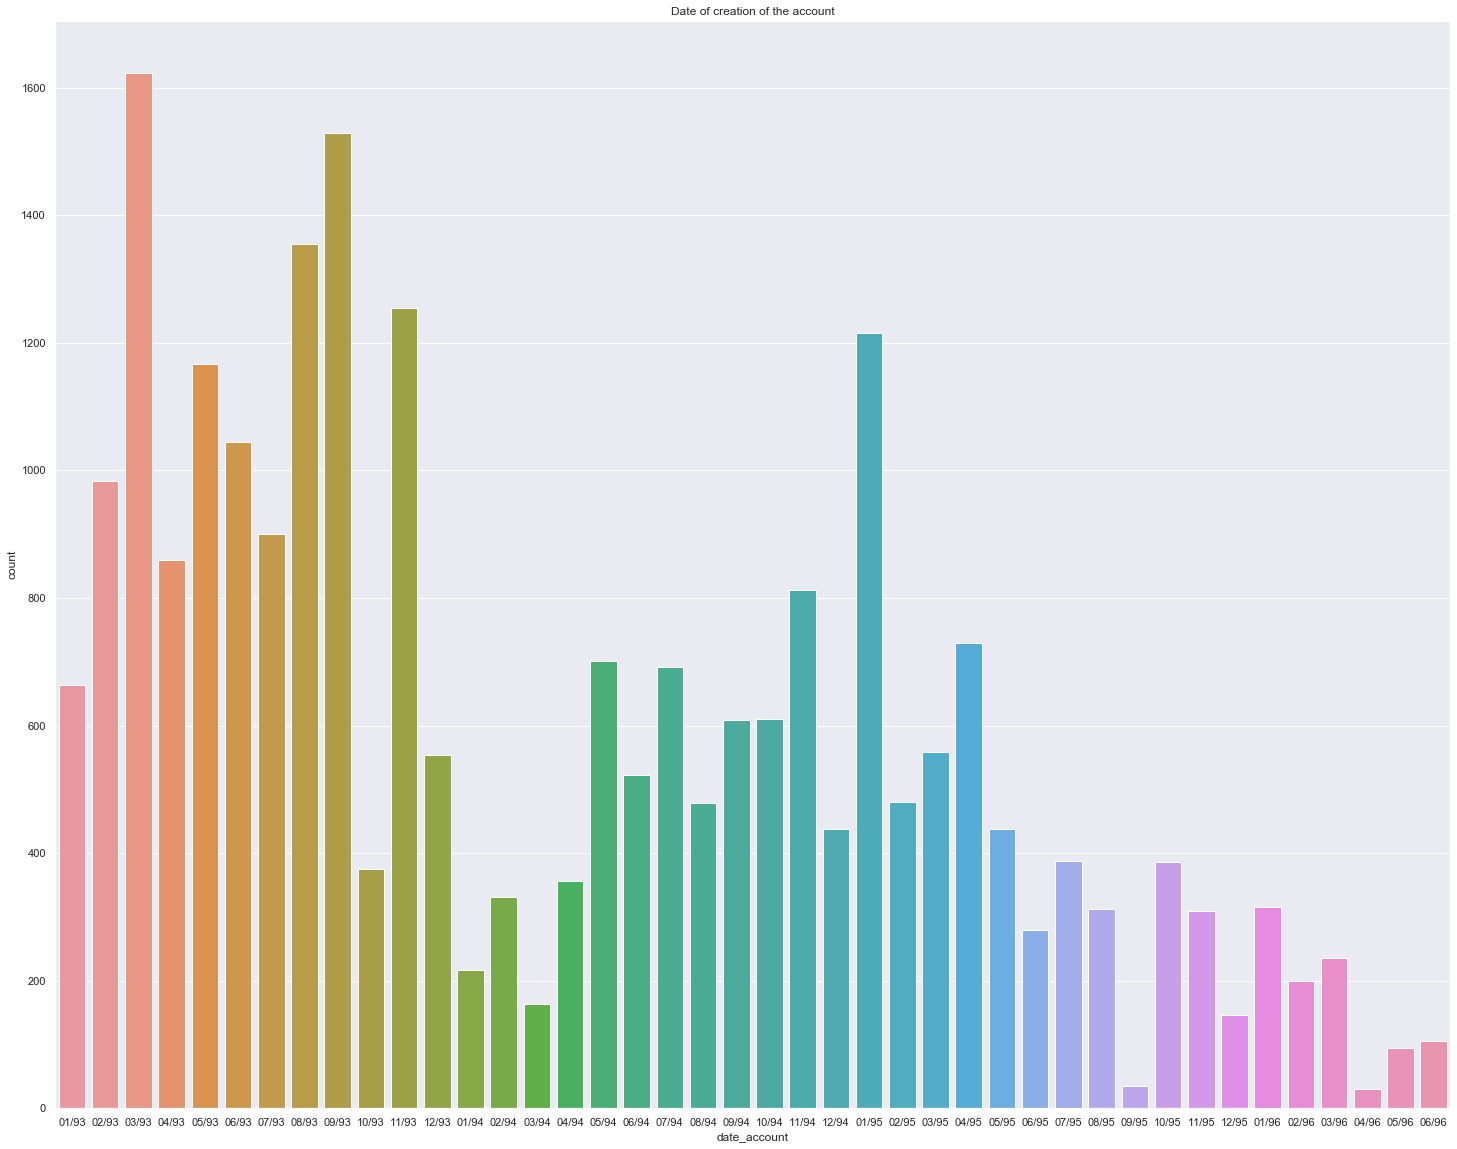

In [252]:
def get_month(year):
    string = year[2:4] + "/" + year[0:2]
    return string

train_data_copy = train_data.copy()
train_data_copy = train_data_copy.sort_values('date_account')
train_data_copy = train_data_copy.astype({'date_account': str})

train_data_copy['date_account'] = train_data_copy['date_account'].apply(lambda x: get_month(x[0:4]))

fig = plt.figure()
plt.figure(figsize=(25,20))
plt.title("Date of creation of the account")
ax = sb.countplot(x="date_account", data=train_data_copy)
plt.show()

We can also see the month and year of when the loans were created and their relation to the number of successful loans.

<Figure size 432x288 with 0 Axes>

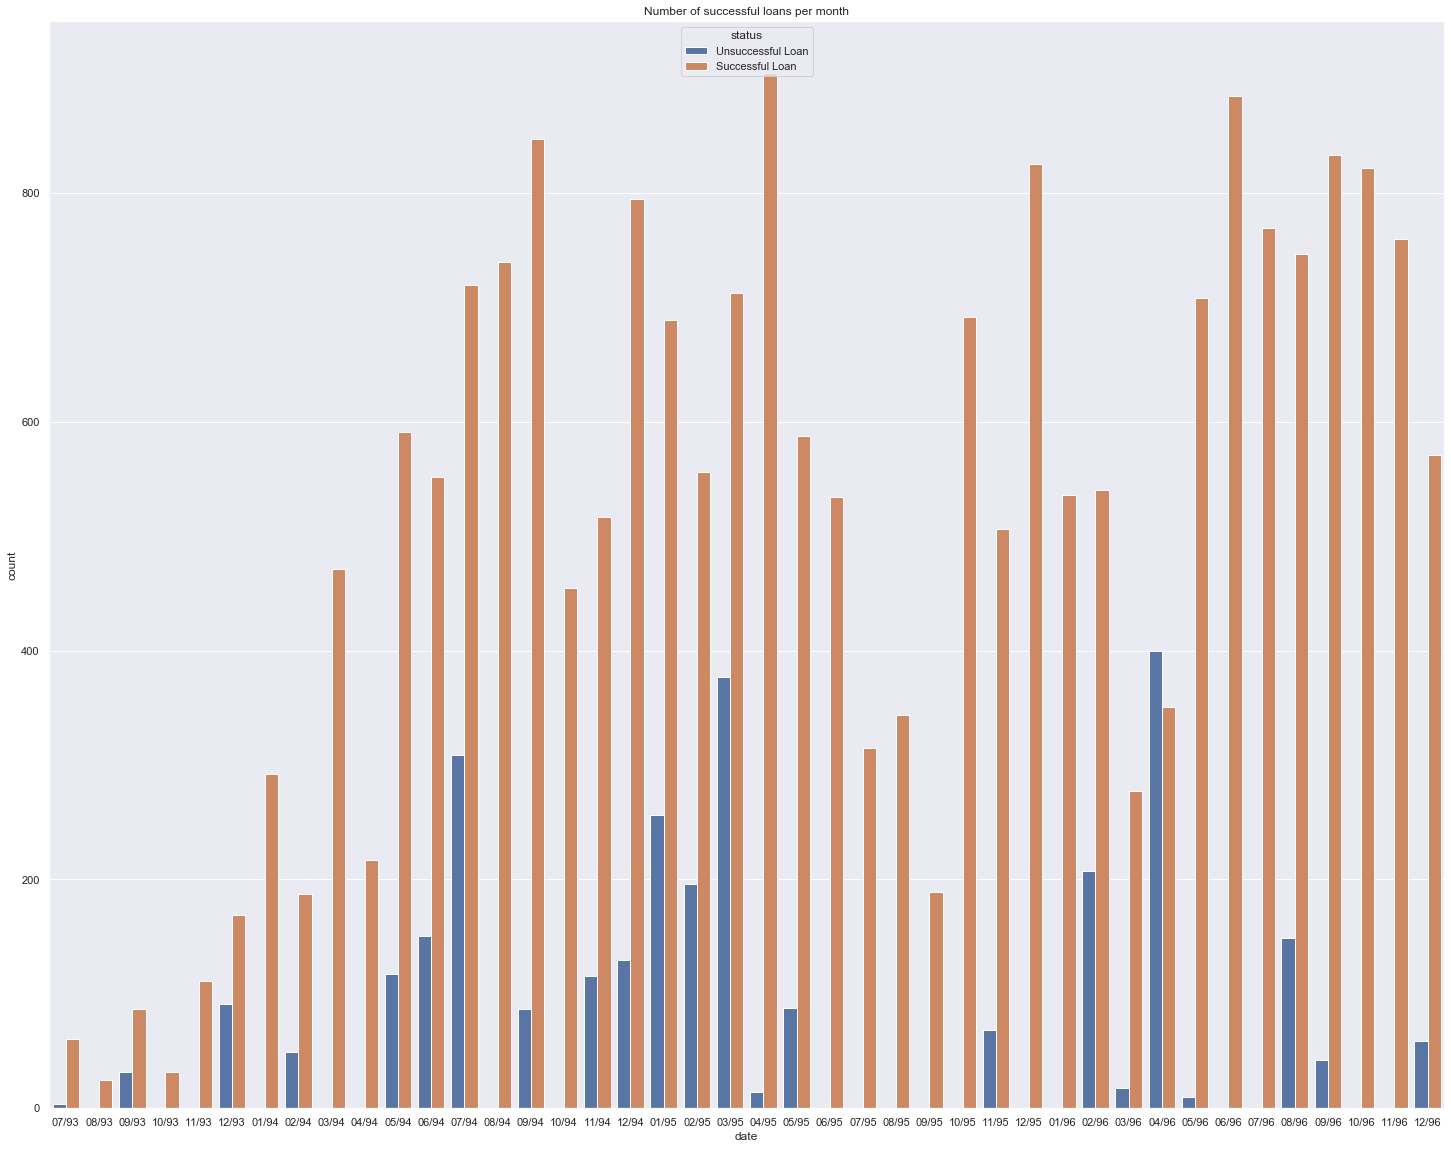

In [253]:
def get_month(year):
    string = year[2:4] + "/" + year[0:2]
    return string

train_data_copy = train_data.copy()
train_data_copy = train_data_copy.sort_values('date')
train_data_copy = train_data_copy.astype({'date': str})

train_data_copy['date'] = train_data_copy['date'].apply(lambda x: get_month(x[0:4]))

train_data_copy = train_data_copy.astype({'status': str})
train_data_copy['status'] = train_data_copy['status'].replace(['1.0','-1.0'],['Successful Loan','Unsuccessful Loan'])

fig = plt.figure()
plt.figure(figsize=(25,20))
plt.title("Number of successful loans per month")
ax = sb.countplot(x ='date', hue = "status", data = train_data_copy)
plt.show()

As follows we can see the months when the most transfers were taken.

<Figure size 432x288 with 0 Axes>

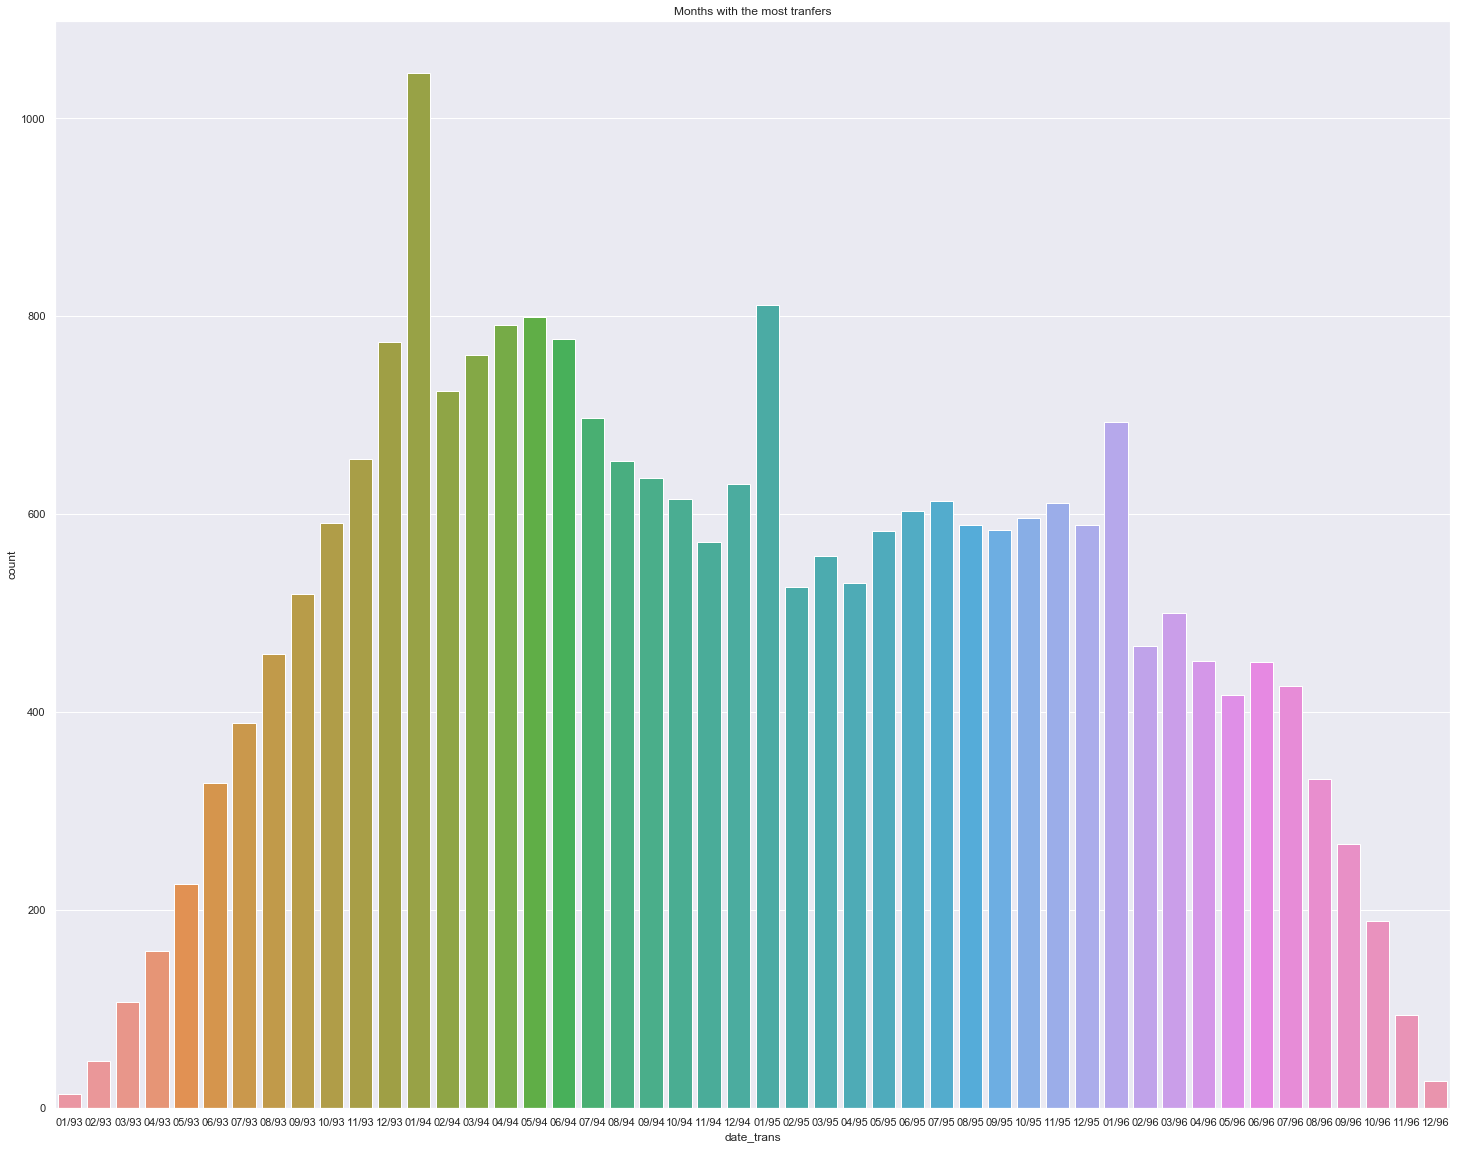

In [254]:
def get_month(year):
    string = year[2:4] + "/" + year[0:2]
    return string

train_data_copy = train_data.copy()
train_data_copy = train_data_copy.sort_values('date_trans')
train_data_copy = train_data_copy.astype({'date_trans': str})

train_data_copy['date_trans'] = train_data_copy['date_trans'].apply(lambda x: get_month(x[0:4]))

fig = plt.figure()
plt.figure(figsize=(25,20))
plt.title("Months with the most tranfers")
ax = sb.countplot(x="date_trans", data=train_data_copy)
plt.show()

In [255]:
# Remove all dates from data, because only the number doesn't make sense. Probably transform it to age?
train_data.drop(['date', 'date_trans', 'date_account'], axis=1, inplace=True)
test_data.drop(['date', 'date_trans', 'date_account'], axis=1, inplace=True)

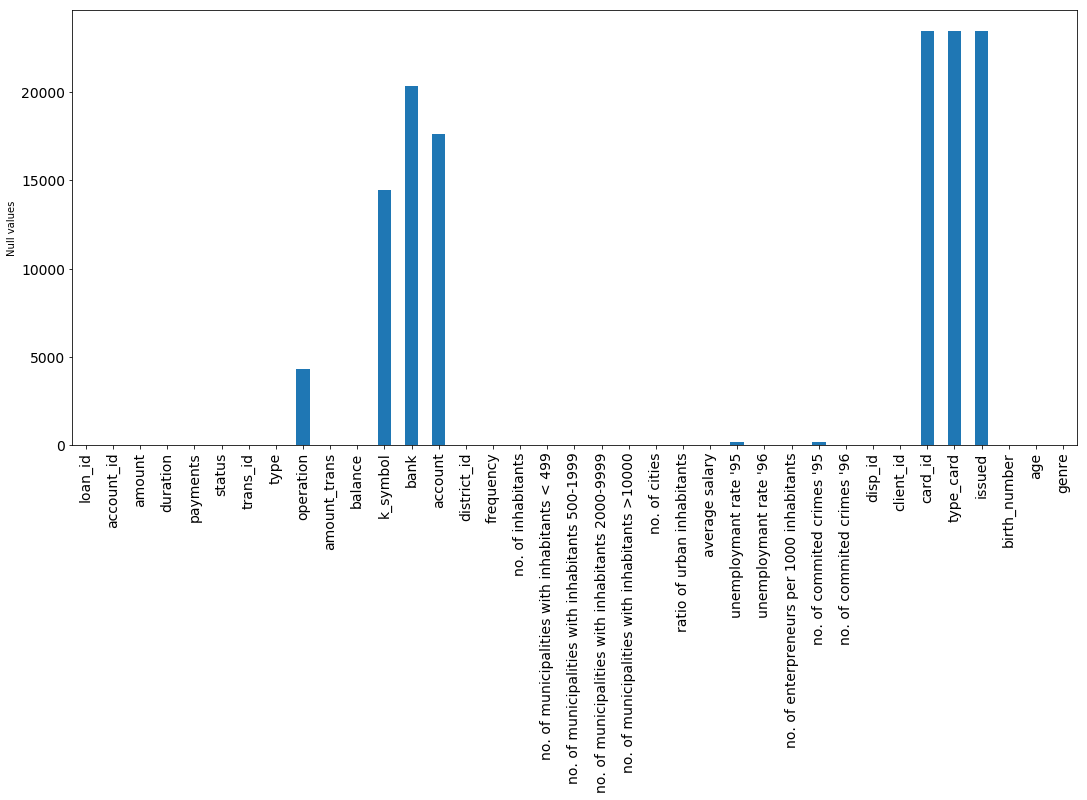

In [256]:
# Null values for each attribute
train_data.isnull().sum().plot(kind='bar', figsize=(18,8), fontsize=14,);
plt.ylabel('Null values');

In [257]:
print('Null values unemploymant rate in \'95:' + str(district_data['unemploymant rate \'95'].isnull().sum()))
print()
print('Null values no. of commited crimes \'95 :' + str(district_data['no. of commited crimes \'95'].isnull().sum()))
print()

Null values unemploymant rate in '95:1

Null values no. of commited crimes '95 :1



In [258]:
train_data_copy = train_data.copy()

train_data_copy = train_data_copy.loc[:, train_data_copy.columns.intersection(['type','operation'])]
train_data_copy["operation"] = train_data_copy["operation"].fillna('NaN')

train_data_copy.sort_values("operation")

print(train_data_copy["type"].unique())
print(train_data_copy["operation"].unique())

['credit' 'withdrawal' 'withdrawal in cash']
['credit in cash' 'NaN' 'withdrawal in cash' 'remittance to another bank'
 'collection from another bank' 'credit card withdrawal']


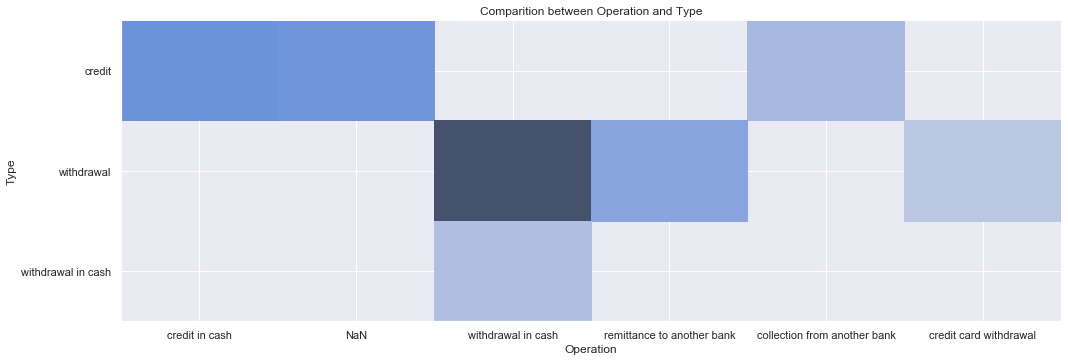

In [259]:
sb.displot(train_data_copy,x='operation', y='type', aspect=3)
plt.xlabel('Operation');
plt.ylabel('Type');
plt.title("Comparition between Operation and Type")
plt.show()

As we can see all the rows with operation *credit in cash* and *collection from another bank* are of type credit. All the *withdrawal in cash*, *remittance to another bank* and *credit cash withdrawal* operations are of the type *withdraw* or *withdrawal with cash* (in the case of the homonymous operation)

C:\Users\pedro\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


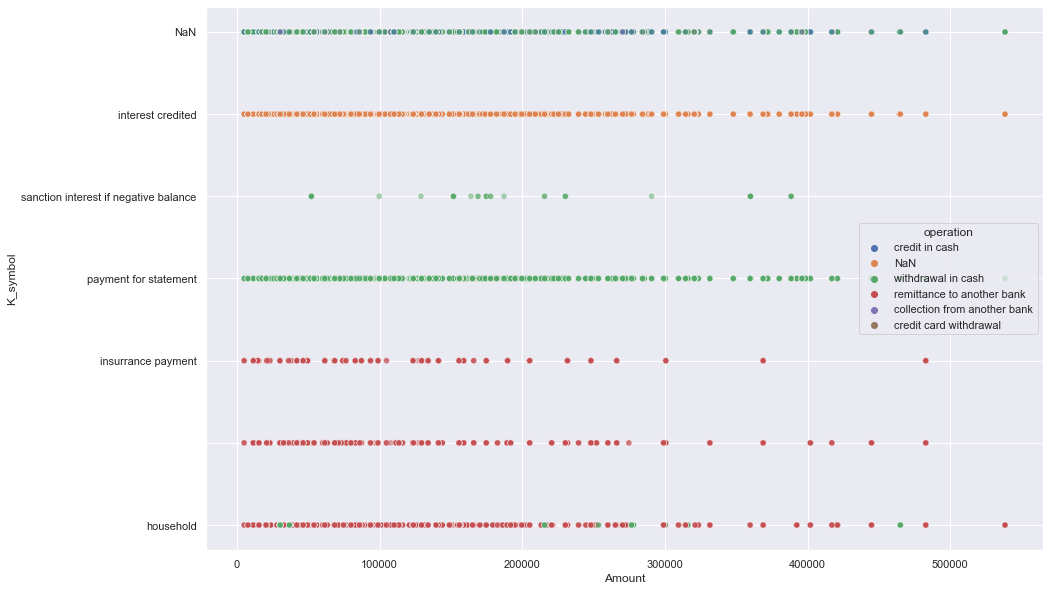

In [260]:
plt.figure(figsize=(15,10))

train_data_copy = train_data.copy()
train_data_copy["operation"] = train_data_copy["operation"].fillna('NaN')
train_data_copy["k_symbol"] = train_data_copy["k_symbol"].fillna('NaN')

sb.scatterplot(train_data_copy["amount"],train_data_copy["k_symbol"],train_data_copy["operation"], alpha=0.5, sizes=(10, 1000), hue="time")
plt.xlabel("Amount")
plt.ylabel("K_symbol")
plt.show()

As we can see the great majority of the k_symbol types are directly related to a certain operation type

[back](#index)
#### District Data <a id="district-data"></a>

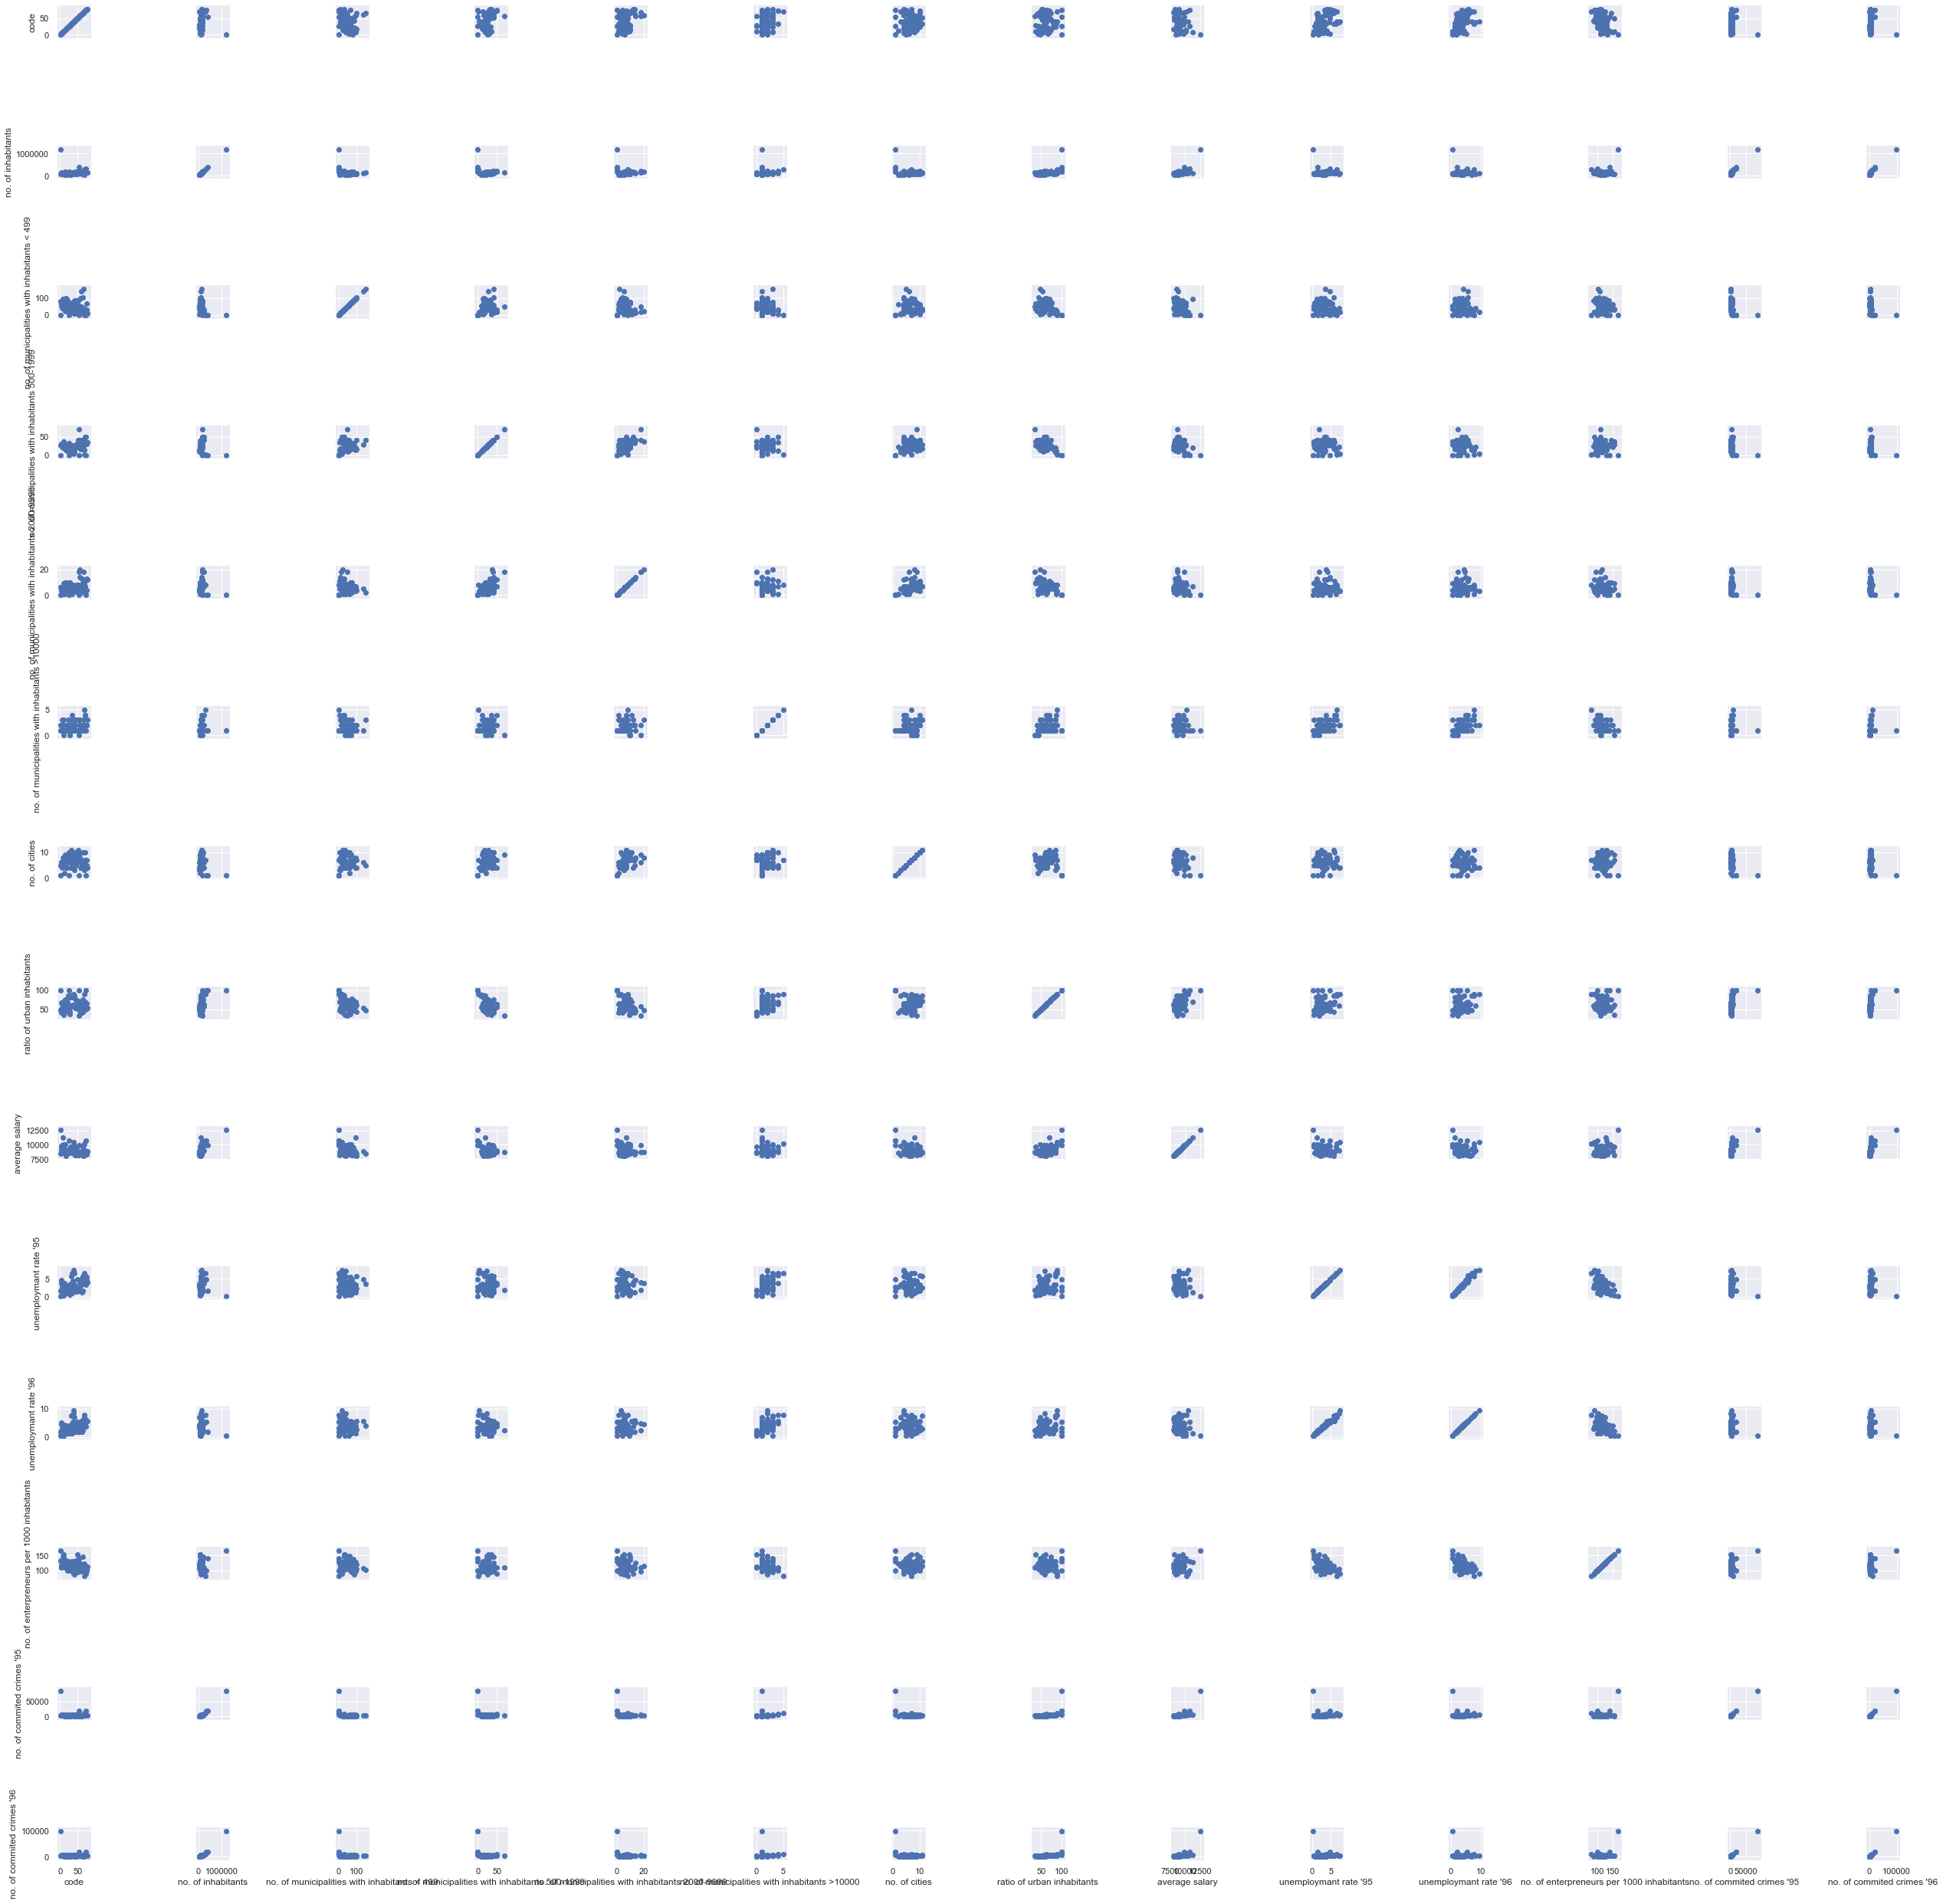

In [261]:
district_scatter_plot = sb.PairGrid(district_data)
district_scatter_plot.map(plt.scatter)

C:\Users\pedro\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\pedro\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 4., 13., 10., 13., 15.,  5.,  6.,  4.,  4.,  2.]),
 array([0.29 , 0.995, 1.7  , 2.405, 3.11 , 3.815, 4.52 , 5.225, 5.93 ,
        6.635, 7.34 ]),
 <a list of 10 Patch objects>)

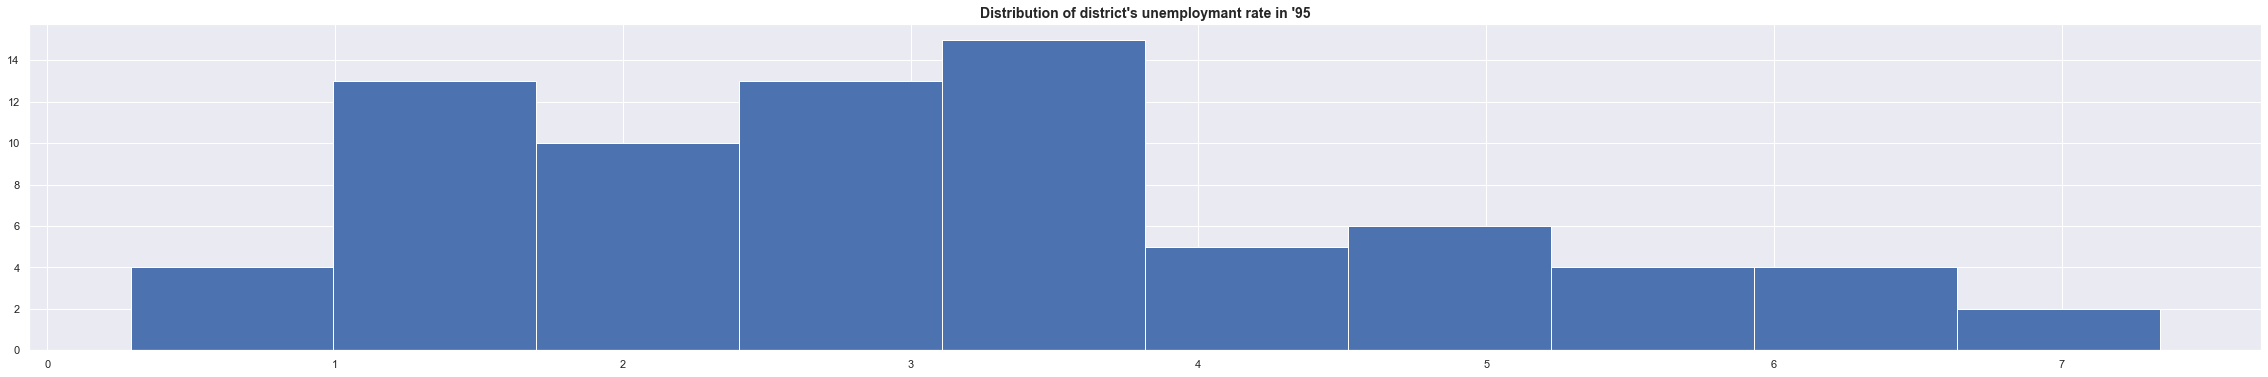

In [262]:
plt.figure(figsize=(40,6))
plt.title('Distribution of district\'s unemploymant rate in \'95', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.hist(district_data['unemploymant rate \'95'])

(array([71.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  818. ,  9303.9, 17789.8, 26275.7, 34761.6, 43247.5, 51733.4,
        60219.3, 68705.2, 77191.1, 85677. ]),
 <a list of 10 Patch objects>)

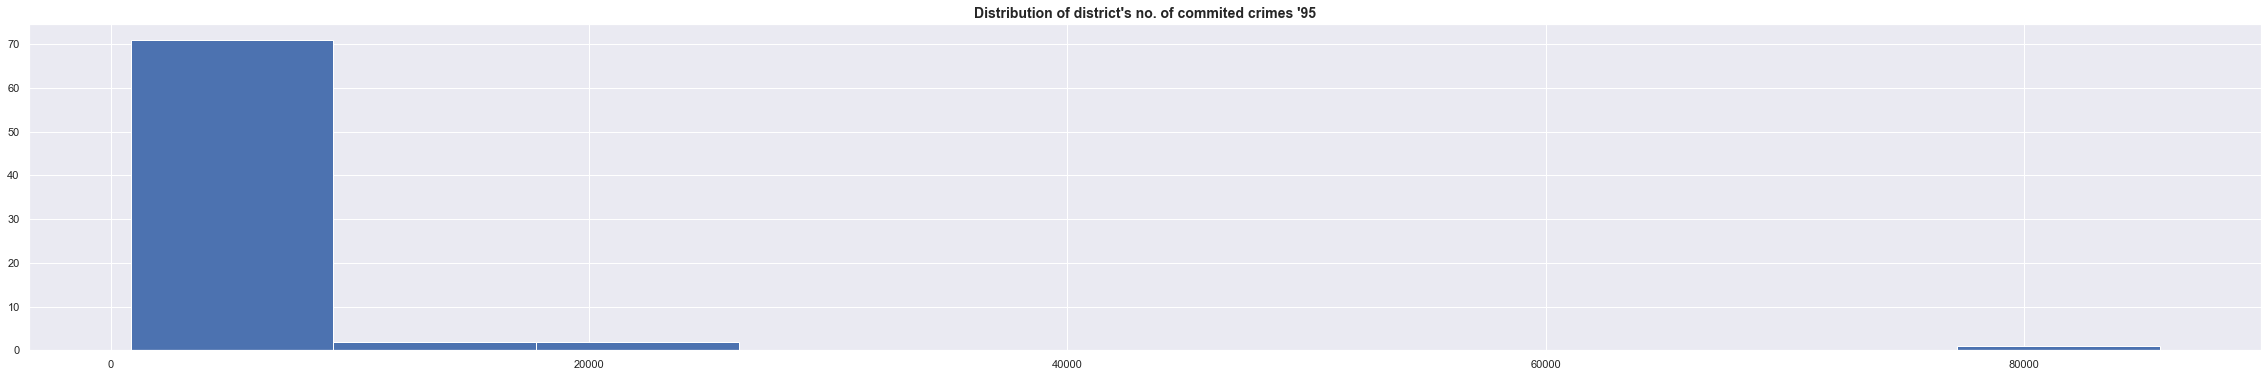

In [263]:
plt.figure(figsize=(40,6))
plt.title('Distribution of district\'s no. of commited crimes \'95', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.hist(district_data['no. of commited crimes \'95'])

In [264]:
# Fill null values in district's unemploymant rate in '95 and district's no. of commited crimes '95
# See if it is better to use median or mean 

train_data['unemploymant rate \'95'].fillna(train_data['unemploymant rate \'95'].median(), inplace=True)

train_data['no. of commited crimes \'95'].fillna(train_data['no. of commited crimes \'95'].mean(), inplace=True)

test_data['unemploymant rate \'95'].fillna(test_data['unemploymant rate \'95'].median(), inplace=True)

test_data['no. of commited crimes \'95'].fillna(test_data['no. of commited crimes \'95'].mean(), inplace=True)

In [265]:
print(train_data.operation.value_counts())
print('Null values: ' + str(train_data.operation.isnull().sum()))
print()
print(train_data.k_symbol.value_counts())
print('Null values: ' + str(train_data.k_symbol.isnull().sum()))
print()
print(train_data.bank.value_counts())
print('Null values: ' + str(train_data.bank.isnull().sum()))
print()
print(train_data.type_card.value_counts())
print('Null values: ' + str(train_data.type_card.isnull().sum()))
print()
print(train_data.type.value_counts())
print('Null values: ' + str(train_data.type.isnull().sum()))
print()

withdrawal in cash              11462
credit in cash                   4506
remittance to another bank       3033
collection from another bank     1139
credit card withdrawal             23
Name: operation, dtype: int64
Null values: 4331

interest credited                        4331
payment for statement                    2528
household                                1724
                                         1001
insurrance payment                        419
sanction interest if negative balance      38
Name: k_symbol, dtype: int64
Null values: 14453

EF    449
YZ    379
ST    375
AB    352
IJ    341
KL    330
GH    328
QR    320
CD    294
UV    287
OP    283
WX    222
MN    212
Name: bank, dtype: int64
Null values: 20322

classic    862
gold        99
junior      77
Name: type_card, dtype: int64
Null values: 23456

withdrawal            13730
credit                 9976
withdrawal in cash      788
Name: type, dtype: int64
Null values: 0



In [266]:
operations_null = train_data[train_data['operation'].isnull()]
operations_null.head()

,loan_id,account_id,amount,duration,payments,status,trans_id,type,operation,amount_trans,...,no. of commited crimes '95,no. of commited crimes '96,disp_id,client_id,card_id,type_card,issued,birth_number,age,genre
7,6903.0,9337.0,52128.0,24.0,2172.0,1.0,3682686.0,credit,NaN,44.1,...,2985.0,2804.0,11189,11497.0,NaN,NaN,NaN,59-07-17,34,0
8,6903.0,9337.0,52128.0,24.0,2172.0,1.0,3456558.0,credit,NaN,44.1,...,2985.0,2804.0,11189,11497.0,NaN,NaN,NaN,59-07-17,34,0
9,6903.0,9337.0,52128.0,24.0,2172.0,1.0,3510168.0,credit,NaN,38.7,...,2985.0,2804.0,11189,11497.0,NaN,NaN,NaN,59-07-17,34,0
11,6903.0,9337.0,52128.0,24.0,2172.0,1.0,3682687.0,credit,NaN,161.9,...,2985.0,2804.0,11189,11497.0,NaN,NaN,NaN,59-07-17,34,0
12,6903.0,9337.0,52128.0,24.0,2172.0,1.0,3456559.0,credit,NaN,162.6,...,2985.0,2804.0,11189,11497.0,NaN,NaN,NaN,59-07-17,34,0


In [267]:
operations_null.k_symbol.value_counts()

interest credited    4331
Name: k_symbol, dtype: int64

All rows that have 'operation' column with null value have 'interested credited' in 'k_symbol' column.

In [268]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24494 entries, 0 to 24493
Data columns (total 37 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   loan_id                                           24494 non-null  float64
 1   account_id                                        24494 non-null  float64
 2   amount                                            24494 non-null  float64
 3   duration                                          24494 non-null  float64
 4   payments                                          24494 non-null  float64
 5   status                                            24494 non-null  float64
 6   trans_id                                          24494 non-null  float64
 7   type                                              24494 non-null  object 
 8   operation                                         20163 non-null  object 
 9   amount_trans     

Representation of the Card Type, with NaN values

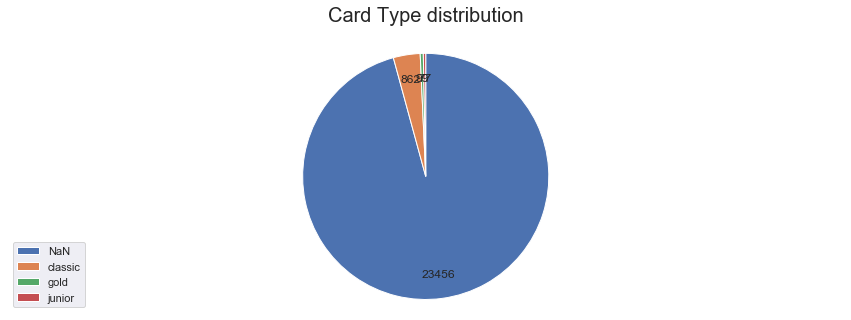

In [269]:
train_data_copy = train_data.copy()

train_data_copy['type_card'] = train_data_copy['type_card'].fillna("NaN")

ser = train_data_copy.groupby('type_card')['type_card'].count()
ser = ser.sort_values(ascending=False)
ser = ser.iloc[[0,1,2,3]]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.pie(ser.values, labels=['','','',''], startangle=90, autopct=lambda x:int(x/100.*ser.sum()+0.1), pctdistance=0.8, counterclock=False)
ax.legend(loc=3, labels=ser.index)
plt.axis('equal')
plt.title('Card Type distribution', y=1.05, fontsize=20)
fig.set_size_inches(15, 5)

Representation of the Card Type, without NaN values

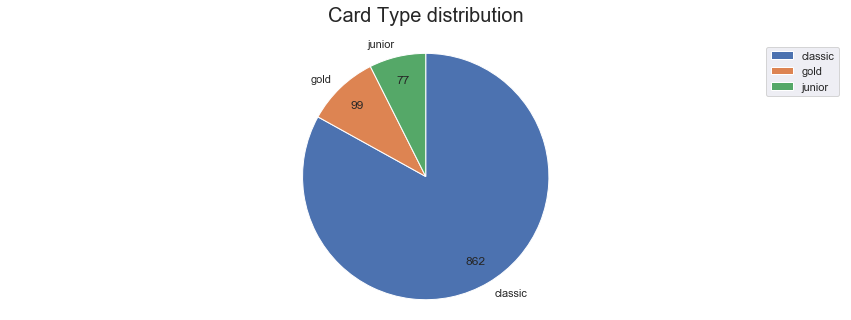

In [270]:
train_data_copy = train_data.copy()

ser = train_data_copy.groupby('type_card')['type_card'].count()
ser = ser.sort_values(ascending=False)
ser = ser.iloc[[0,1,2]]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.pie(ser.values, labels=ser.index, startangle=90, autopct=lambda x:int(x/100.*ser.sum()+0.1), pctdistance=0.8, counterclock=False)
ax.legend()
plt.axis('equal')
plt.title('Card Type distribution', y=1.05, fontsize=20)
fig.set_size_inches(15, 5)

[back](#index)
#### Dataset Managing <a id="dataset"></a>

In [271]:
# needs to be checked
option = 1
if option ==1:
    train_data.drop(['bank', 'k_symbol', 'account', 'operation', 'issued'], axis=1, inplace=True)
    test_data.drop(['bank', 'k_symbol', 'account', 'operation', 'issued'], axis=1, inplace=True)
#replaced withdrawal in cash with only withdrawal
elif option==2:
    train_data.drop(['bank', 'k_symbol', 'account', 'operation', 'issued'], axis=1, inplace=True)
    test_data.drop(['bank', 'k_symbol', 'account', 'operation', 'issued'], axis=1, inplace=True)
    train_data.replace('withdrawal in cash', 'withdrawal', inplace=True)
    test_data.replace('withdrawal in cash', 'withdrawal', inplace=True)
#filled nulls from operation with k_symbol
elif option==3:
    train_data['operation'].fillna(train_data['k_symbol'], inplace=True)
    test_data['operation'].fillna(test_data['k_symbol'], inplace=True)
    train_data.drop(['bank', 'k_symbol', 'account', 'issued'], axis=1, inplace=True)
    test_data.drop(['bank', 'k_symbol', 'account', 'issued'], axis=1, inplace=True)
#joined operation and k_symbol
elif option==4:
    train_data['operation'].fillna(train_data['k_symbol'], inplace=True)
    test_data['operation'].fillna(test_data['k_symbol'], inplace=True)
    train_data['k_symbol'].fillna(train_data['operation'], inplace=True)
    test_data['k_symbol'].fillna(test_data['operation'], inplace=True)
    train_data['operation']=train_data['operation'] + ' ' + train_data['k_symbol']
    test_data['operation']=test_data['operation'] + ' ' + test_data['k_symbol']
    train_data["operation"] = train_data["operation"].apply(lambda x: ' '.join(pd.unique(x.split())))
    test_data["operation"] = test_data["operation"].apply(lambda x: ' '.join(pd.unique(x.split())))
    train_data.drop(['bank', 'k_symbol', 'account', 'issued'], axis=1, inplace=True)
    test_data.drop(['bank', 'k_symbol', 'account', 'issued'], axis=1, inplace=True)
#joined operation and k_symbol and dropped type
elif option==5:
    train_data['operation'].fillna(train_data['k_symbol'], inplace=True)
    test_data['operation'].fillna(test_data['k_symbol'], inplace=True)
    train_data['k_symbol'].fillna(train_data['operation'], inplace=True)
    test_data['k_symbol'].fillna(test_data['operation'], inplace=True)
    train_data['operation']=train_data['operation'] + ' ' + train_data['k_symbol']
    test_data['operation']=test_data['operation'] + ' ' + test_data['k_symbol']
    train_data["operation"] = train_data["operation"].apply(lambda x: ' '.join(pd.unique(x.split())))
    test_data["operation"] = test_data["operation"].apply(lambda x: ' '.join(pd.unique(x.split())))
    train_data.drop(['bank', 'k_symbol', 'account', 'issued', 'type'], axis=1, inplace=True)
    test_data.drop(['bank', 'k_symbol', 'account', 'issued', 'type'], axis=1, inplace=True)
    

In [272]:
train_data = pd.get_dummies(train_data, columns=['frequency'], dtype=bool)
test_data = pd.get_dummies(test_data, columns=['frequency'], dtype=bool)

train_data = pd.get_dummies(train_data, columns=['type_card'], dtype = bool)
test_data = pd.get_dummies(test_data, columns=['type_card'], dtype = bool)

# train_data = pd.get_dummies(train_data, columns=['type_disp'], dtype = bool)
# test_data = pd.get_dummies(test_data, columns=['type_disp'], dtype = bool)

if option != 5:
    train_data = pd.get_dummies(train_data, columns=['type'], dtype = bool)
    test_data = pd.get_dummies(test_data, columns=['type'], dtype = bool)

if option == 3 or option == 4:
    train_data = pd.get_dummies(train_data, columns=['operation'], dtype = bool)
    test_data = pd.get_dummies(test_data, columns=['operation'], dtype = bool)

test_data = test_data.drop_duplicates(subset=['loan_id'], keep='first')

#train_data = pd.get_dummies(train_data)
#test_data = pd.get_dummies(test_data)

train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24494 entries, 0 to 24493
Data columns (total 38 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   loan_id                                           24494 non-null  float64
 1   account_id                                        24494 non-null  float64
 2   amount                                            24494 non-null  float64
 3   duration                                          24494 non-null  float64
 4   payments                                          24494 non-null  float64
 5   status                                            24494 non-null  float64
 6   trans_id                                          24494 non-null  float64
 7   amount_trans                                      24494 non-null  float64
 8   balance                                           24494 non-null  float64
 9   district_id      

In [273]:
train_data.head()

,loan_id,account_id,amount,duration,payments,status,trans_id,amount_trans,balance,district_id,...,genre,frequency_issuance after transaction,frequency_monthly issuance,frequency_weekly issuance,type_card_classic,type_card_gold,type_card_junior,type_credit,type_withdrawal,type_withdrawal in cash
0,5314.0,1787.0,96396.0,12.0,8033.0,-1.0,523621.0,1100.0,1100.0,30.0,...,0,False,False,True,False,False,False,True,False,False
1,5314.0,1787.0,96396.0,12.0,8033.0,-1.0,524054.0,9900.0,11000.0,30.0,...,0,False,False,True,False,False,False,True,False,False
2,5314.0,1787.0,96396.0,12.0,8033.0,-1.0,524055.0,5800.0,16800.0,30.0,...,0,False,False,True,False,False,False,True,False,False
3,5314.0,1787.0,96396.0,12.0,8033.0,-1.0,524056.0,3300.0,20100.0,30.0,...,0,False,False,True,False,False,False,True,False,False
4,6903.0,9337.0,52128.0,24.0,2172.0,1.0,2820215.0,900.0,900.0,30.0,...,0,False,True,False,False,False,False,True,False,False


In [274]:
competition_inputs = test_data.drop(columns=["loan_id", "status"])
# test_data = test_data.drop(columns=["status"])
all_ids_comp = test_data['loan_id'].values

#### [back](#index)
#### Data Exploration <a class="anchor" id="data-exploration"></a>

After the previous changes we end up with the following columns to study

In [275]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354 entries, 0 to 30084
Data columns (total 37 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   loan_id                                           354 non-null    int64  
 1   account_id                                        354 non-null    int64  
 2   amount                                            354 non-null    int64  
 3   duration                                          354 non-null    int64  
 4   payments                                          354 non-null    int64  
 5   trans_id                                          354 non-null    int64  
 6   amount_trans                                      354 non-null    float64
 7   balance                                           354 non-null    float64
 8   district_id                                       354 non-null    int64  
 9   no. of inhabitants 

C:\Users\pedro\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


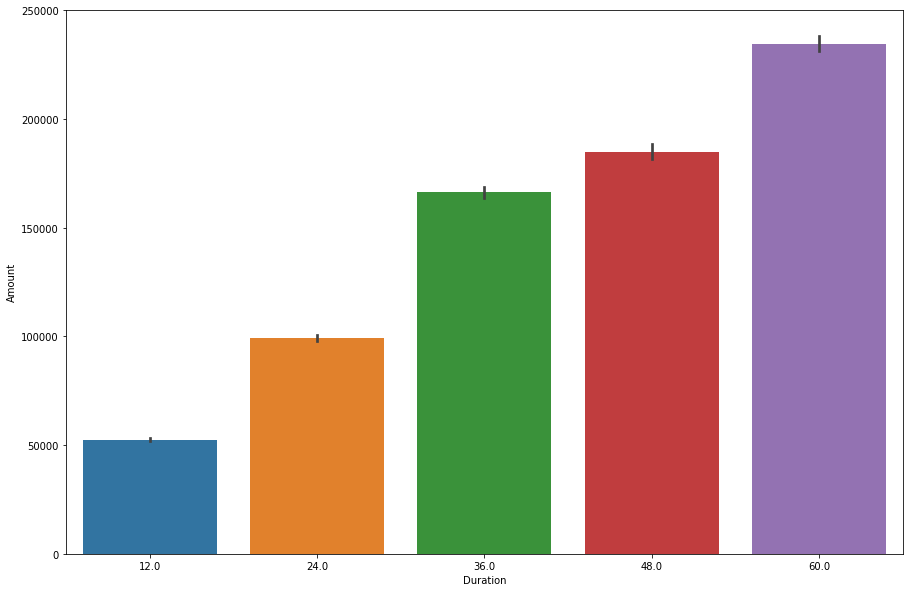

In [276]:
plt.figure(figsize=(15,10))
ax = sb.barplot(train_data["duration"], train_data["amount"])
plt.xlabel('Duration');
plt.ylabel('Amount');
plt.show()

We can clearly see that with bigger loan amounts the time taken to repay them is exponentially higher 

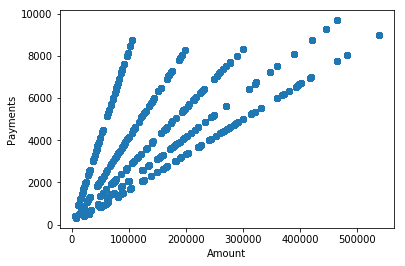

In [277]:
ax = plt.plot(train_data["amount"], train_data["payments"], linestyle='none', marker='o', alpha=0.3)
plt.xlabel('Amount');
plt.ylabel('Payments');
plt.show()

As we can check by the values in the graph, it seems that the number of payments is defined by the bank since the results are very linear and follow a line according to the amount loaned

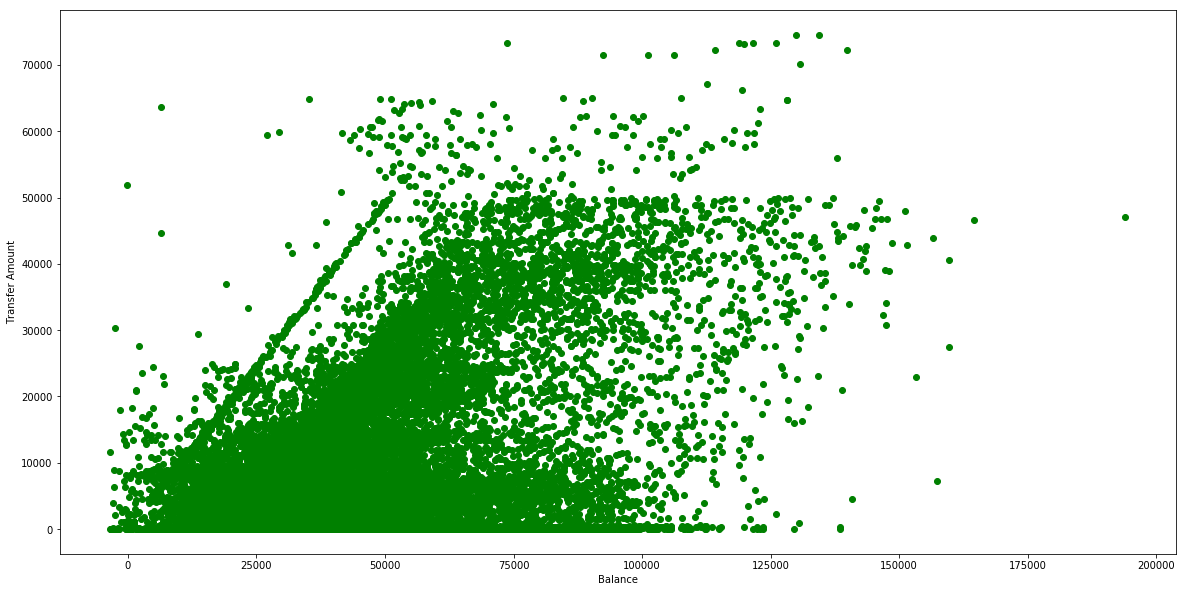

In [278]:
plt.figure(figsize=(20,10))
#ax = sb.barplot(train_data["amount_trans"], train_data["balance"])
plt.plot(train_data["balance"],train_data["amount_trans"], 'o', color='green');
plt.ylabel('Transfer Amount');
plt.xlabel('Balance');
plt.show()

As we can see as the balance increases the transfer amount also increase and is rarely higher than the balance. It can also be seen that a straight continous line exists with gradient 1. This means the amount of some transfers are actually correspondent, or close, to the total amount in the account.

C:\Users\pedro\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


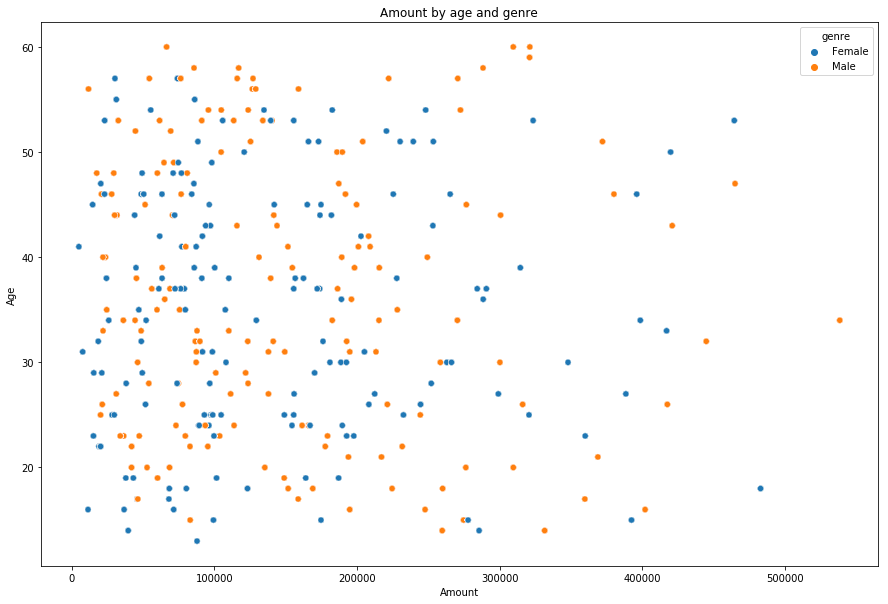

In [279]:
plt.figure(figsize=(15,10))

train_data_names = train_data.copy()
train_data_names["genre"] = train_data_names["genre"].astype(str)
train_data_names["genre"].replace({"1": "Male" , "0": "Female"}, inplace=True)

sb.scatterplot(train_data_names["amount"],train_data_names["age"],train_data_names["genre"], alpha=0.5, sizes=(10, 1000), hue="time")
plt.xlabel("Amount")
plt.ylabel("Age")
plt.title("Amount by age and genre")
plt.show()

C:\Users\pedro\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


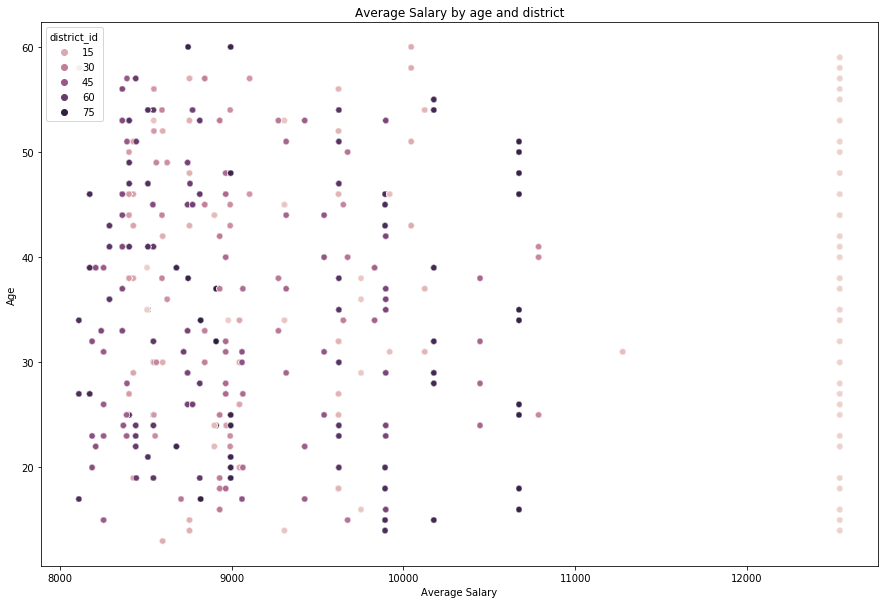

In [280]:
plt.figure(figsize=(15,10))

train_data_names = train_data.copy()
train_data_names["genre"] = train_data_names["genre"].astype(str)
train_data_names["genre"].replace({"1": "Male" , "0": "Female"}, inplace=True)

sb.scatterplot(train_data_names["average salary"],train_data_names["age"],train_data_names["district_id"], alpha=0.5, sizes=(10, 1000), hue="time")
plt.xlabel("Average Salary")
plt.ylabel("Age")
plt.title("Average Salary by age and district")
plt.show()

As follows we can see the average salary by age

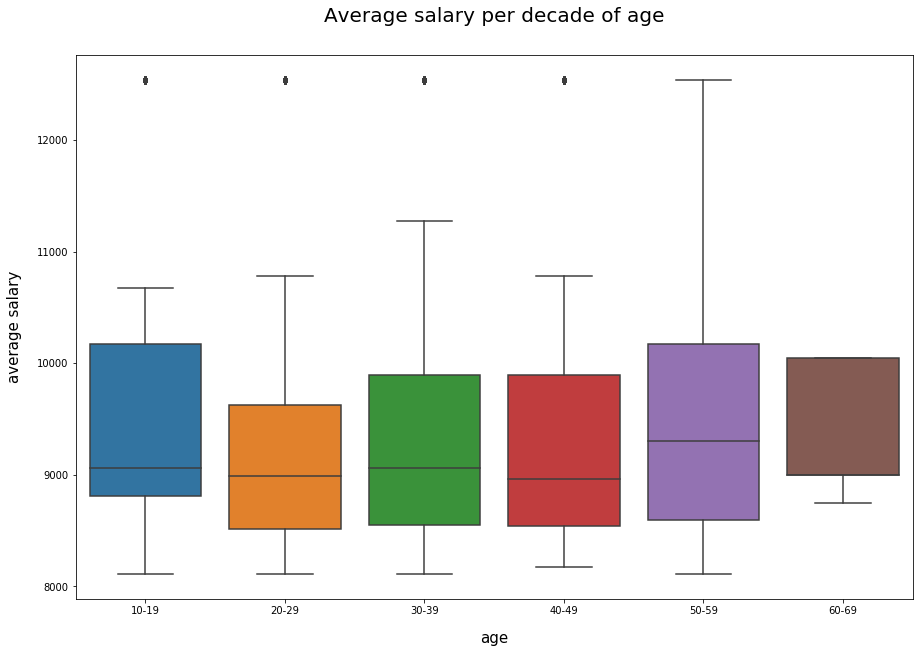

In [295]:
def get_decade(year):
    year_int = int(year)
    string = str(year_int//10) + "0-" + str(year_int//10) + "9"
    return string

train_data_copy = train_data.copy()
train_data_copy = train_data_copy.astype({'age': str})

train_data_copy['age'] = train_data_copy['age'].apply(lambda x: get_decade(x))

train_data_copy = train_data_copy.sort_values('age')
train_data_copy["average salary"] = train_data_copy["average salary"].astype(float)

fig = plt.figure()
sb.boxplot(x=train_data_copy["age"], y=train_data_copy["average salary"])
plt.xlabel('age', y=1.05, fontsize=15, labelpad=15)
plt.ylabel('average salary', x=0.7, fontsize=15, labelpad=15)
plt.title('Average salary per decade of age', y=1.05, fontsize=20)
fig.set_size_inches(15, 10)
plt.show()


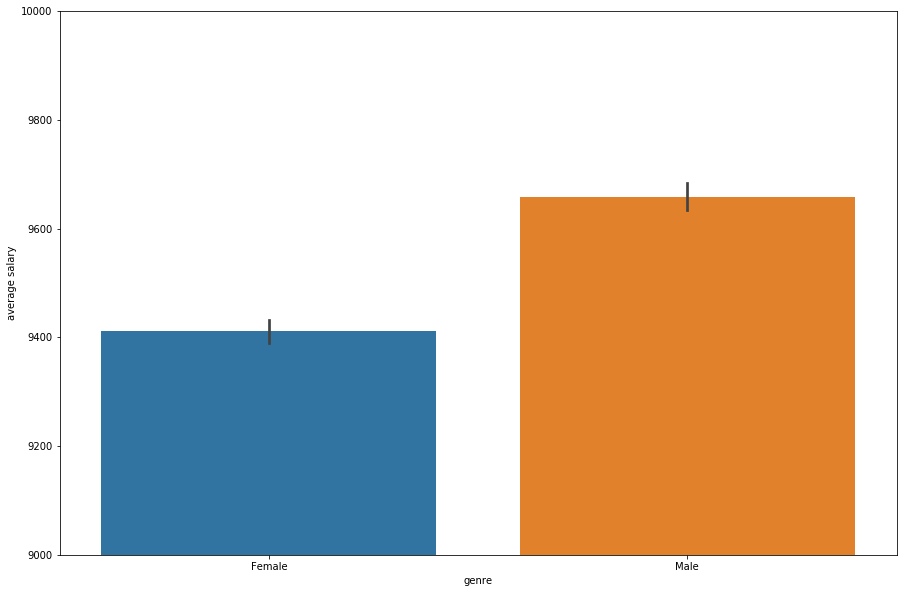

In [282]:
train_data_copy = train_data.copy()
train_data_copy["genre"] = train_data_copy["genre"].astype(str)
train_data_copy["genre"].replace({"0": "Female","1": "Male"}, inplace=True)

plt.figure(figsize=(15,10))
plt.ylim(9000, 10000)
sb.barplot(x = train_data_copy["genre"], y = train_data_copy["average salary"])
# display
plt.show()

[back](#index)
#### Matrix <a id="matrix"></a>

train_data_w /test_data_w : train/test data where withdrawals in cash are replaced by withdrawals

3 Dropped columns: ["unemploymant rate '96", "no. of commited crimes '95", "no. of commited crimes '96"]


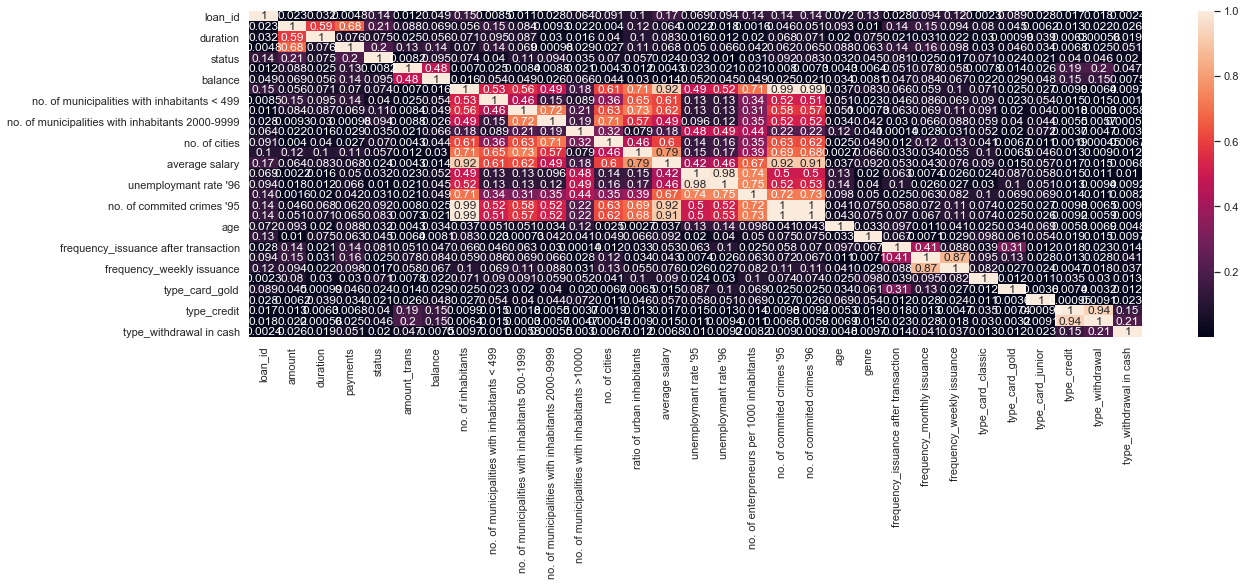

In [169]:
# Dropping ids
#train_data_no_ids = train_data.drop(['loan_id', 'account_id', 'district_id', 'disp_id', 'client_id', 'card_id', 'trans_id'], axis=1)
train_data_no_ids = train_data.drop(['client_id', 'account_id', 'district_id', 'disp_id', 'card_id', 'trans_id'], axis=1)
test_data_no_ids = test_data.drop(['client_id', 'account_id', 'district_id', 'disp_id', 'card_id', 'trans_id'], axis=1)


# Create correlation matrix
corr_matrix = train_data_no_ids.corr().abs()
plt.figure(figsize = (20,6))
sb.heatmap(corr_matrix, annot=True)

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
train_data_no_ids.drop(to_drop, axis=1, inplace=True)
test_data_no_ids.drop(to_drop, axis=1, inplace=True)

print("{} Dropped columns: {}".format(len(to_drop), to_drop) )

In [170]:
train_data_no_ids.head()

,loan_id,amount,duration,payments,status,amount_trans,balance,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,...,genre,frequency_issuance after transaction,frequency_monthly issuance,frequency_weekly issuance,type_card_classic,type_card_gold,type_card_junior,type_credit,type_withdrawal,type_withdrawal in cash
0,5314.0,96396.0,12.0,8033.0,-1.0,1100.0,1100.0,94812.0,15.0,13.0,...,0,False,False,True,False,False,False,True,False,False
1,5314.0,96396.0,12.0,8033.0,-1.0,9900.0,11000.0,94812.0,15.0,13.0,...,0,False,False,True,False,False,False,True,False,False
2,5314.0,96396.0,12.0,8033.0,-1.0,5800.0,16800.0,94812.0,15.0,13.0,...,0,False,False,True,False,False,False,True,False,False
3,5314.0,96396.0,12.0,8033.0,-1.0,3300.0,20100.0,94812.0,15.0,13.0,...,0,False,False,True,False,False,False,True,False,False
4,6903.0,52128.0,24.0,2172.0,1.0,900.0,900.0,94812.0,15.0,13.0,...,0,False,True,False,False,False,False,True,False,False


In [33]:
# Removing rows with nan values for status
#train_data_no_ids.dropna(subset=["status"], inplace=True)

#print(no_ids.drop_duplicates(inplace=True)
print(train_data_no_ids["status"].value_counts())

In [172]:
train_data_no_ids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24494 entries, 0 to 24493
Data columns (total 28 columns):
loan_id                                             24494 non-null float64
amount                                              24494 non-null float64
duration                                            24494 non-null float64
payments                                            24494 non-null float64
status                                              24494 non-null float64
amount_trans                                        24494 non-null float64
balance                                             24494 non-null float64
no. of inhabitants                                  24494 non-null float64
no. of municipalities with inhabitants < 499        24494 non-null float64
no. of municipalities with inhabitants 500-1999     24494 non-null float64
no. of municipalities with inhabitants 2000-9999    24494 non-null float64
no. of municipalities with inhabitants >10000       24494 non-null

In [173]:
train_data_no_ids.head()

,loan_id,amount,duration,payments,status,amount_trans,balance,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,...,genre,frequency_issuance after transaction,frequency_monthly issuance,frequency_weekly issuance,type_card_classic,type_card_gold,type_card_junior,type_credit,type_withdrawal,type_withdrawal in cash
0,5314.0,96396.0,12.0,8033.0,-1.0,1100.0,1100.0,94812.0,15.0,13.0,...,0,False,False,True,False,False,False,True,False,False
1,5314.0,96396.0,12.0,8033.0,-1.0,9900.0,11000.0,94812.0,15.0,13.0,...,0,False,False,True,False,False,False,True,False,False
2,5314.0,96396.0,12.0,8033.0,-1.0,5800.0,16800.0,94812.0,15.0,13.0,...,0,False,False,True,False,False,False,True,False,False
3,5314.0,96396.0,12.0,8033.0,-1.0,3300.0,20100.0,94812.0,15.0,13.0,...,0,False,False,True,False,False,False,True,False,False
4,6903.0,52128.0,24.0,2172.0,1.0,900.0,900.0,94812.0,15.0,13.0,...,0,False,True,False,False,False,False,True,False,False


In [174]:
all_inputs = train_data_no_ids[train_data_no_ids.columns.drop(['loan_id', 'status'])]
all_labels = train_data_no_ids['status'].values

# competition_inputs = test_data_no_ids.drop(columns=["loan_id"])
# all_ids_comp = test_data_no_ids['loan_id'].values

#all_inputs = train_data_no_ids.iloc[:, :-1].values
#all_labels = train_data_no_ids.iloc[:, -1].values

In [175]:
# get a test dataset with 25% of the credit_data_subset
(X_train, X_test, y_train, y_test) = train_test_split(all_inputs, all_labels, test_size=0.25, random_state=1)

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

#### [back](#index)
## Decision Tree <a class="anchor" id="decision-tree"></a>



In [ ]:
# Create the classifier
decision_tree_classifier = DecisionTreeClassifier()

# Train the classifier on the training set
decision_tree_classifier.fit(X_train, y_train)

dtc_prediction = decision_tree_classifier.predict(X_test)

dtc_classification_report = classification_report(y_test, dtc_prediction, output_dict=True)

print(f"Classification report:\n{classification_report(y_test, dtc_prediction)}\n")

sb.set(font_scale=1.0)
 
ax = plt.subplot()

confusion_matrix_dtc = confusion_matrix(y_test, dtc_prediction)

sb.heatmap(confusion_matrix_dtc, annot=True, ax=ax, fmt="g")

ax.set_xlabel('Predicted Grades');
ax.set_ylabel('Observed Grades');
ax.set_title('Confusion Matrix');
plt.show()


### Parameter Tunning <a class="anchor" id="parameter-tunning"></a>

In [ ]:
parameter_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': range(10, 20),
                  'max_features': range(10,20)}

grid_search = GridSearchCV(DecisionTreeClassifier(),
                           param_grid=parameter_grid,
                           cv=10,
                           verbose=4,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best estimator: {}'.format(grid_search.best_estimator_))

In [ ]:
decision_tree_classifier = grid_search.best_estimator_
dtc_prediction = decision_tree_classifier.predict(X_test)

best_dtc_classification_report = classification_report(y_test, dtc_prediction, output_dict=True)

print("--- Improved model ---\n")
print(f"Classification report:\n{classification_report(y_test, dtc_prediction)}\n")

sb.set(font_scale=1.0)

ax = plt.subplot()

confusion_matrix_dtc = confusion_matrix(y_test, dtc_prediction)

sb.heatmap(confusion_matrix_dtc, annot=True, ax=ax, fmt="g")

ax.set_xlabel('Predicted Grades');
ax.set_ylabel('Observed Grades');
ax.set_title('Confusion Matrix');
plt.show()

#### [back](#index)
## K-Nearest Neighbor <a class="anchor" id="k-nearest-neighbor"></a>

In [ ]:
knn = KNeighborsClassifier()

knn.fit(X_train, y_train)
knn_prediction = knn.predict(X_test)

knn_classification_report = classification_report(y_test, knn_prediction, output_dict=True)

print(f"Classification report:\n{classification_report(y_test, knn_prediction, labels=np.unique(y_train))}\n")

sb.set(font_scale=1.0)

ax = plt.subplot()

confusion_matrix_knn = confusion_matrix(y_test, knn_prediction)

sb.heatmap(confusion_matrix_knn, annot=True, ax=ax, fmt="g")

ax.set_xlabel('Predicted Grades');
ax.set_ylabel('Observed Grades');
ax.set_title('Confusion Matrix');
plt.show()

### Parameter Tunning <a class="anchor" id="parameter-tunning-2"></a>

In [ ]:
parameter_grid = {'n_neighbors': [5,10,15,20],
                  'weights': ['uniform', 'distance'],
                  'algorithm': ['ball_tree', 'kd_tree', 'brute']}

grid_search = GridSearchCV(KNeighborsClassifier(),
                           param_grid=parameter_grid,
                           scoring='precision_weighted',
                           cv=10,
                           n_jobs=3,
                           verbose=4)

grid_search.fit(X_train, y_train)
print(f"Best score: {grid_search.best_score_}")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best estimator: {grid_search.best_estimator_}")

In [ ]:
knn = grid_search.best_estimator_
yk_pred = knn.predict(X_test)

best_knn_classification_report = classification_report(y_test, yk_pred, output_dict=True)

print("--- Improved model ---\n")
print(f"Classification report:\n{classification_report(y_test, yk_pred)}\n")

sb.set(font_scale=1.0)

ax = plt.subplot()

confusion_matrix_knn = confusion_matrix(y_test, yk_pred)

sb.heatmap(confusion_matrix_knn, annot=True, ax=ax, fmt="g")

ax.set_xlabel('Predicted Grades');
ax.set_ylabel('Observed Grades');
ax.set_title('Confusion Matrix');
plt.show()

#### [back](#index)
## Support-Vector Machines <a class="anchor" id="support-vector-machines"></a>

Classification report:
              precision    recall  f1-score   support

        -1.0       0.26      0.69      0.37       734
         1.0       0.94      0.73      0.82      5390

    accuracy                           0.72      6124
   macro avg       0.60      0.71      0.60      6124
weighted avg       0.86      0.72      0.77      6124




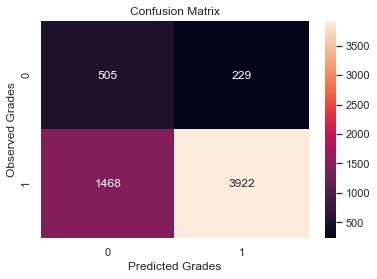

In [176]:
svc = SVC(probability=True)

svc.fit(X_train, y_train)
svc_prediction = svc.predict(X_test)

svm_classification_report = classification_report(y_test, svc_prediction, output_dict=True)

print(f"Classification report:\n{classification_report(y_test, svc_prediction)}\n")

sb.set(font_scale=1.0)

ax = plt.subplot()

confusion_matrix_svm = confusion_matrix(y_test, svc_prediction)

sb.heatmap(confusion_matrix_svm, annot=True, ax=ax, fmt="g")

ax.set_xlabel('Predicted Grades');
ax.set_ylabel('Observed Grades');
ax.set_title('Confusion Matrix');
plt.show()

best_svm_classification_report = svm_classification_report

### Parameter Tunning <a class="anchor" id="parameter-tunning-3"></a>

In [ ]:
parameter_grid = {'C' : [0.1, 1, 10], 
                'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

grid_search = GridSearchCV(SVC(),
                           param_grid=parameter_grid,
                           cv=10,
                           verbose=4,
                           n_jobs=4)

grid_search.fit(X_train, y_train)
print(f"Best score: {grid_search.best_score_}")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best estimator: {grid_search.best_estimator_}")

In [ ]:
svc = grid_search.best_estimator_
yk_pred = svc.predict(X_test)

best_svm_classification_report = classification_report(y_test, yk_pred, output_dict=True)

print("--- Improved model ---\n")
print(f"Classification report:\n{best_knn_classification_report(y_test, yk_pred)}\n")

sb.set(font_scale=1.0)

ax = plt.subplot()

confusion_matrix_svm = confusion_matrix(y_test, yk_pred)

sb.heatmap(confusion_matrix_svm, annot=True, ax=ax, fmt="g")

ax.set_xlabel('Predicted Grades');
ax.set_ylabel('Observed Grades');
ax.set_title('Confusion Matrix');
plt.show()

#### [back](#index)
## Neural Networks <a class="anchor" id="neural-networks"></a>

In [ ]:
scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_train)

# Now apply the transformations to the data:
X_train_nn = scaler.transform(X_train)
X_test_nn = scaler.transform(X_test)

# Create the classifier
ANNClassifier = MLPClassifier(random_state=1, max_iter=500)

# Train the classifier on the training set
ANNClassifier.fit(X_train_nn, y_train)

predictions = ANNClassifier.predict(X_test_nn)

confusion_matrix_ann = confusion_matrix(y_test,predictions)

nn_classification_report = classification_report(y_test, predictions, output_dict=True)
print(classification_report(y_test,predictions))

sb.set(font_scale=1.0)

ax = plt.subplot()

sb.heatmap(confusion_matrix_ann, annot=True, ax=ax, fmt="g")

ax.set_xlabel('Predicted Grades');
ax.set_ylabel('Observed Grades');
ax.set_title('Confusion Matrix');
plt.show()

best_nn_classification_report = nn_classification_report

### Parameter Tunning <a class="anchor" id="parameter-tunning-4"></a>

In [ ]:
parameter_grid = {'activation': ['tanh','identity','logistic','relu'],
                  'solver': ['adam','lbfgs','sgd'],
                  'hidden_layer_sizes': [3,5,8,13,21,34],
                  'verbose': [True]}

cross_validation = StratifiedKFold(n_splits=10, shuffle=True)

grid_search = GridSearchCV(ANNClassifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(X_train, y_train)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best estimator: {}'.format(grid_search.best_estimator_))

In [ ]:
ANNClassifier = grid_search.best_estimator_
yk_pred = ANNClassifier.predict(X_test)

best_nn_classification_report = classification_report(y_test, yk_pred, output_dict=True)

print("--- Improved model ---\n")
print(f"Classification report:\n{best_nn_classification_report(y_test, yk_pred)}\n")

sb.set(font_scale=1.0)

ax = plt.subplot()

confusion_matrix_ann = confusion_matrix(y_test, yk_pred)

sb.heatmap(confusion_matrix_ann, annot=True, ax=ax, fmt="g")

ax.set_xlabel('Predicted Grades');
ax.set_ylabel('Observed Grades');
ax.set_title('Confusion Matrix');
plt.show()

In [ ]:
test_data_no_ids.info()

In [177]:
test_inputs = test_data_no_ids.drop(columns=['status', 'loan_id'])

pred_comp = svc.predict_proba(test_inputs)

pred_comp = pd.DataFrame(pred_comp, columns=['col2', 'Predicted'])

pred_comp.drop('col2', axis=1, inplace=True)
all_ids_comp = pd.DataFrame(all_ids_comp, columns=['Id'])
results = pd.concat([all_ids_comp, pred_comp], axis=1)
#results = results.rename(columns={"loan_id":"Id"})
results.to_csv('results.csv', index = False)

print(results)

       Id  Predicted
0    5895   0.378576
1    5172   0.500000
2    6207   0.197084
3    7122   0.115095
4    7067   0.236300
5    6173   0.278926
6    6705   0.392225
7    5889   0.373645
8    5036   0.511182
9    6142   0.167929
10   6938   0.172160
11   5932   0.558267
12   5398   0.485357
13   6855   0.506204
14   6632   0.258853
15   5358   0.558633
16   5674   0.190639
17   5384   0.612702
18   5589   0.266747
19   5042   0.189598
20   6095   0.550893
21   7049   0.239274
22   6075   0.362751
23   6878   0.693517
24   5790   0.512984
25   5532   0.358258
26   6118   0.391680
27   6442   0.282563
28   6554   0.332820
29   5973   0.202843
..    ...        ...
324  7279   0.284208
325  5463   0.677168
326  6355   0.303722
327  6675   0.147351
328  5620   0.567335
329  4988   0.174174
330  5765   0.256661
331  7091   0.353841
332  5933   0.476872
333  6470   0.588935
334  5841   0.616183
335  6574   0.435025
336  5525   0.385070
337  5435   0.165355
338  7168   0.176405
339  5909   0